## Esports Decision Intelligence Framework: Predictive Models for Players, Teams and Viewership

#### Basic imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, zscore, probplot, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    silhouette_score,
)
from sklearn.cluster import KMeans

import pickle
import joblib

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

sns.set(style="whitegrid")

#### Paths & Helper Utilities

In [2]:
RAW_DATA_DIR = os.path.join("data", "raw data")
CLEAN_DATA_DIR = os.path.join("data", "cleaned data")
MODELS_DIR = "models"

os.makedirs(CLEAN_DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Raw data dir:", RAW_DATA_DIR)
print("Cleaned data dir:", CLEAN_DATA_DIR)
print("Models dir:", MODELS_DIR)

Raw data dir: data\raw data
Cleaned data dir: data\cleaned data
Models dir: models


#### Column Name & File Loading Helpers

In [3]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize dataframe column names:
    - strip spaces
    - lowercase
    - replace spaces and hyphens with underscores
    """
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df


def try_read_dataset(base_dir: str, stem: str):
    """
    Try to read a dataset as CSV first, then XLSX.
    `stem` should be the filename without extension.
    """
    csv_path = os.path.join(base_dir, f"{stem}.csv")
    xlsx_path = os.path.join(base_dir, f"{stem}.xlsx")

    if os.path.exists(csv_path):
        print(f"Loading CSV: {csv_path}")
        return pd.read_csv(csv_path)
    elif os.path.exists(xlsx_path):
        print(f"Loading Excel: {xlsx_path}")
        return pd.read_excel(xlsx_path)
    else:
        raise FileNotFoundError(
            f"Neither CSV nor XLSX file found for stem '{stem}' in '{base_dir}'"
        )

#### Safe Plotting Helpers

Every plotting helper will:
- Check column existence
- Check that the column is numeric where required
- Print a friendly message instead of raising errors

In [4]:
def ensure_numeric_series(series: pd.Series):
    """Convert a series to numeric if possible, keeping NaNs."""
    if pd.api.types.is_numeric_dtype(series):
        return series
    return pd.to_numeric(series, errors="coerce")


def safe_histplot(df, col, title="", bins=30):
    if col not in df.columns:
        print(f"[safe_histplot] Column '{col}' not found. Skipping.")
        return
    data = ensure_numeric_series(df[col]).dropna()
    if data.empty:
        print(f"[safe_histplot] Column '{col}' is not numeric or has no data. Skipping.")
        return
    plt.figure(figsize=(8, 5))
    sns.histplot(data, bins=bins, kde=True)
    plt.title(title or f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


def safe_boxplot(df, x, y, title=""):
    if y not in df.columns:
        print(f"[safe_boxplot] Column '{y}' not found. Skipping.")
        return
    if x not in df.columns:
        print(f"[safe_boxplot] Column '{x}' not found. Skipping.")
        return
    y_data = ensure_numeric_series(df[y])
    if y_data.dropna().empty:
        print(f"[safe_boxplot] Column '{y}' not numeric/usable. Skipping.")
        return
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=x, y=y)
    plt.title(title or f"{y} by {x}")
    plt.tight_layout()
    plt.show()


def safe_barplot(series, title="", xlabel="", ylabel="Value"):
    if series is None or series.empty:
        print("[safe_barplot] Series is empty. Skipping.")
        return
    plt.figure(figsize=(10, 5))
    series.sort_values(ascending=False).plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90, ha="center")
    plt.tight_layout()
    plt.show()


def safe_corr_heatmap(df, title="Correlation Heatmap"):
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] < 2:
        print("[safe_corr_heatmap] Not enough numeric columns for correlation. Skipping.")
        return
    plt.figure(figsize=(8, 6))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f", square=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def safe_scatter(df, x, y, hue=None, title=""):
    for col in [x, y]:
        if col not in df.columns:
            print(f"[safe_scatter] Column '{col}' not found. Skipping.")
            return
    x_data = ensure_numeric_series(df[x])
    y_data = ensure_numeric_series(df[y])
    if x_data.dropna().empty or y_data.dropna().empty:
        print("[safe_scatter] One of the columns is non-numeric or empty. Skipping.")
        return
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.title(title or f"{y} vs {x}")
    plt.tight_layout()
    plt.show()

#### Column Detection Helpers

In [5]:
def find_column_by_keywords(df: pd.DataFrame, keywords, must_be_numeric=False):
    """
    Find the first column whose name contains ANY of the given keywords.
    keywords: list of lowercase substrings
    """
    cols = df.columns
    for col in cols:
        col_l = col.lower()
        if any(k in col_l for k in keywords):
            if must_be_numeric:
                if pd.api.types.is_numeric_dtype(df[col]) or pd.to_numeric(
                    df[col], errors="coerce"
                ).notna().any():
                    return col
            else:
                return col
    return None


def get_twitch_streamer_columns(df):
    name_col = find_column_by_keywords(df, ["channel", "streamer", "name"])
    followers_col = find_column_by_keywords(df, ["follower"], must_be_numeric=True)
    avg_viewers_col = find_column_by_keywords(df, ["avg_view", "average_view"], must_be_numeric=True)
    peak_viewers_col = find_column_by_keywords(df, ["peak_view"], must_be_numeric=True)
    hours_watched_col = find_column_by_keywords(df, ["hours_watched", "hrs_watched", "watch_time"], must_be_numeric=True)
    partner_col = find_column_by_keywords(df, ["partner"])
    return {
        "name": name_col,
        "followers": followers_col,
        "avg_viewers": avg_viewers_col,
        "peak_viewers": peak_viewers_col,
        "hours_watched": hours_watched_col,
        "partner": partner_col,
    }


def get_twitch_game_columns(df):
    # Try to detect game/category name normally
    game_col = find_column_by_keywords(df, ["game", "category", "title"])

    # Fallback: first non-numeric column as "game/category"
    if game_col is None:
        non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
        if non_numeric_cols:
            game_col = non_numeric_cols[0]
            print(f"[get_twitch_game_columns] Falling back to non-numeric column "
                  f"'{game_col}' as game/category name.")
        else:
            print("[get_twitch_game_columns] No suitable non-numeric column for game/category.")

    avg_viewers_col = find_column_by_keywords(
        df, ["avg_view", "average_view"], must_be_numeric=True
    )
    peak_viewers_col = find_column_by_keywords(
        df, ["peak_view"], must_be_numeric=True
    )
    hours_watched_col = find_column_by_keywords(
        df, ["hours_watched", "hrs_watched", "watch_time"], must_be_numeric=True
    )

    # Fallback for hours watched: first numeric column
    if hours_watched_col is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if numeric_cols:
            hours_watched_col = numeric_cols[0]
            print(f"[get_twitch_game_columns] Falling back to numeric column "
                  f"'{hours_watched_col}' as hours_watched.")
        else:
            print("[get_twitch_game_columns] No numeric column available for hours_watched.")

    return {
        "game": game_col,
        "avg_viewers": avg_viewers_col,
        "peak_viewers": peak_viewers_col,
        "hours_watched": hours_watched_col,
    }


def get_growth_columns(df):
    year_col = find_column_by_keywords(df, ["year"])
    revenue_col = find_column_by_keywords(df, ["revenue", "income"])
    audience_col = find_column_by_keywords(df, ["audience", "viewers", "viewership"])
    region_col = find_column_by_keywords(df, ["region", "continent", "area"])
    return {
        "year": year_col,
        "revenue": revenue_col,
        "audience": audience_col,
        "region": region_col,
    }

#### Load all raw datasets

In [6]:
df_country_raw = try_read_dataset(RAW_DATA_DIR, "country_continent mapping_dataset")
df_growth_raw = try_read_dataset(RAW_DATA_DIR, "global_esports_growth_dataset")
df_players_raw = try_read_dataset(RAW_DATA_DIR, "players_earnings_dataset")
df_teams_raw = try_read_dataset(RAW_DATA_DIR, "teams_earnings_dataset")
df_twitch_streamers_raw = try_read_dataset(RAW_DATA_DIR, "twitch_streamers_viewership_dataset")
df_twitch_games_raw = try_read_dataset(RAW_DATA_DIR, "twitch_game-level_viewership_dataset")

Loading CSV: data\raw data\country_continent mapping_dataset.csv
Loading CSV: data\raw data\global_esports_growth_dataset.csv
Loading CSV: data\raw data\players_earnings_dataset.csv
Loading CSV: data\raw data\teams_earnings_dataset.csv
Loading CSV: data\raw data\twitch_streamers_viewership_dataset.csv
Loading CSV: data\raw data\twitch_game-level_viewership_dataset.csv


#### Standardize column names

In [7]:
df_country = standardize_column_names(df_country_raw)
df_growth = standardize_column_names(df_growth_raw)
df_players = standardize_column_names(df_players_raw)
df_teams = standardize_column_names(df_teams_raw)
df_twitch_streamers = standardize_column_names(df_twitch_streamers_raw)
df_twitch_games = standardize_column_names(df_twitch_games_raw)

for name, df in [
    ("country", df_country),
    ("growth", df_growth),
    ("players", df_players),
    ("teams", df_teams),
    ("twitch_streamers", df_twitch_streamers),
    ("twitch_games", df_twitch_games),
]:
    print(f"{name} columns:\n", df.columns.tolist(), "\n")

country columns:
 ['continent_name', 'continent_code', 'country_name', 'two_letter_country_code', 'three_letter_country_code', 'country_number'] 

growth columns:
 ['year', 'country', 'region', 'gaming_revenue_billionusd', 'esports_revenue_millionusd', 'active_players_million', 'esports_viewers_million', 'avg_spending_usd', 'top_genre', 'top_platform', 'esports_tournaments_count', 'pro_players_count', 'internet_penetration_percent', 'avg_latency_ms', 'ar_vr_adoption_index', 'streaming_influence_index', 'covid_impact_index', 'female_gamer_percent', 'mobile_gaming_share', 'esports_prizepool_millionusd', 'gaming_companies_count'] 

players columns:
 ['playerid', 'namefirst', 'namelast', 'currenthandle', 'countrycode', 'totalusdprize', 'game', 'genre'] 

teams columns:
 ['teamid', 'teamname', 'totalusdprize', 'totaltournaments', 'game', 'genre'] 

twitch_streamers columns:
 ['profile_picture', 'top_count', 'screen_name', 'watch_time', 'stream_time', 'peak_viewers', 'average_viewers', 'foll

#### Numeric Imputation Helper

In [8]:
def median_impute_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
    return df

#### Merge Players with Country–Continent Mapping

- Verify required columns exist (after standardization)

In [9]:
print("Country mapping sample:")
display(df_country.head())

print("Players sample:")
display(df_players.head())

Country mapping sample:


,continent_name,continent_code,country_name,two_letter_country_code,three_letter_country_code,country_number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0


Players sample:


,playerid,namefirst,namelast,currenthandle,countrycode,totalusdprize,game,genre
0,3883,Peter,Rasmussen,dupreeh,dk,1822989.41,Counter-Strike: Global Offensive,First-Person Shooter
1,3679,Andreas,Højsleth,Xyp9x,dk,1799288.57,Counter-Strike: Global Offensive,First-Person Shooter
2,3885,Nicolai,Reedtz,dev1ce,dk,1787489.88,Counter-Strike: Global Offensive,First-Person Shooter
3,3672,Lukas,Rossander,gla1ve,dk,1652350.75,Counter-Strike: Global Offensive,First-Person Shooter
4,17800,Emil,Reif,Magisk,dk,1416448.64,Counter-Strike: Global Offensive,First-Person Shooter


#### Median imputation for numeric columns before merge

In [10]:
df_country = median_impute_numeric(df_country)
df_players = median_impute_numeric(df_players)

#### Standardize country code values on both sides

In [11]:
# Clean player country codes (2-letter)
if "countrycode" in df_players.columns:
    df_players["countrycode"] = (
        df_players["countrycode"]
        .astype(str)
        .str.strip()
        .str.upper()
    )

# Clean mapping 2-letter codes, if present
if "two_letter_country_code" in df_country.columns:
    df_country["two_letter_country_code"] = (
        df_country["two_letter_country_code"]
        .astype(str)
        .str.strip()
        .str.upper()
    )

# Clean mapping 3-letter codes, if present
if "three_letter_country_code" in df_country.columns:
    df_country["three_letter_country_code"] = (
        df_country["three_letter_country_code"]
        .astype(str)
        .str.strip()
        .str.upper()
    )

print("Sample player country codes:", df_players["countrycode"].unique()[:10])
if "two_letter_country_code" in df_country.columns:
    print("Sample mapping 2-letter codes:", df_country["two_letter_country_code"].unique()[:10])
if "three_letter_country_code" in df_country.columns:
    print("Sample mapping 3-letter codes:", df_country["three_letter_country_code"].unique()[:10])


Sample player country codes: ['DK' 'US' 'BR' 'CA' 'SE' 'FR' 'SK' 'NO' 'BA' 'RU']
Sample mapping 2-letter codes: ['AF' 'AL' 'AQ' 'DZ' 'AS' 'AD' 'AO' 'AG' 'AZ' 'AR']
Sample mapping 3-letter codes: ['AFG' 'ALB' 'ATA' 'DZA' 'ASM' 'AND' 'AGO' 'ATG' 'AZE' 'ARG']


#### Perform merge using three-letter country code

In [12]:
# Perform merge between players and country mapping using country codes
players_country_code_col = "countrycode"  # from players

# Prefer 2-letter codes if they exist in the mapping, otherwise fall back to 3-letter
if "two_letter_country_code" in df_country.columns:
    country_mapping_code_col = "two_letter_country_code"
    print("Merging players with country mapping on 2-letter country codes.")
elif "three_letter_country_code" in df_country.columns:
    country_mapping_code_col = "three_letter_country_code"
    print("Merging players with country mapping on 3-letter country codes.")
else:
    raise KeyError(
        "Country mapping must contain either 'two_letter_country_code' "
        "or 'three_letter_country_code'."
    )

# Safety checks
if players_country_code_col not in df_players.columns:
    raise KeyError(f"Expected column '{players_country_code_col}' not found in players data.")

if country_mapping_code_col not in df_country.columns:
    raise KeyError(f"Expected column '{country_mapping_code_col}' not found in country mapping data.")

# Merge players with country mapping
df_players_merged = df_players.merge(
    df_country,
    left_on=players_country_code_col,
    right_on=country_mapping_code_col,
    how="left",
)

Merging players with country mapping on 2-letter country codes.


#### Fill missing region / country info with default values

In [13]:
for col, default_val in [
    ("continent_name", "Unknown"),
    ("continent_code", "UNK"),
    ("country_name", "Unknown"),
]:
    if col in df_players_merged.columns:
        df_players_merged[col].fillna(default_val, inplace=True)
    else:
        # If column doesn't exist, create it with default
        df_players_merged[col] = default_val

In [14]:
print("Players merged columns:")
print(df_players_merged.columns.tolist())
df_players_merged.head()

Players merged columns:
['playerid', 'namefirst', 'namelast', 'currenthandle', 'countrycode', 'totalusdprize', 'game', 'genre', 'continent_name', 'continent_code', 'country_name', 'two_letter_country_code', 'three_letter_country_code', 'country_number']


,playerid,namefirst,namelast,currenthandle,countrycode,totalusdprize,game,genre,continent_name,continent_code,country_name,two_letter_country_code,three_letter_country_code,country_number
0,3883,Peter,Rasmussen,dupreeh,DK,1822989.41,Counter-Strike: Global Offensive,First-Person Shooter,Europe,EU,"Denmark, Kingdom of",DK,DNK,208.0
1,3679,Andreas,Højsleth,Xyp9x,DK,1799288.57,Counter-Strike: Global Offensive,First-Person Shooter,Europe,EU,"Denmark, Kingdom of",DK,DNK,208.0
2,3885,Nicolai,Reedtz,dev1ce,DK,1787489.88,Counter-Strike: Global Offensive,First-Person Shooter,Europe,EU,"Denmark, Kingdom of",DK,DNK,208.0
3,3672,Lukas,Rossander,gla1ve,DK,1652350.75,Counter-Strike: Global Offensive,First-Person Shooter,Europe,EU,"Denmark, Kingdom of",DK,DNK,208.0
4,17800,Emil,Reif,Magisk,DK,1416448.64,Counter-Strike: Global Offensive,First-Person Shooter,Europe,EU,"Denmark, Kingdom of",DK,DNK,208.0


#### Handle Teams (continent as Unknown if missing)

In [15]:
df_teams = median_impute_numeric(df_teams)

if "continent_name" not in df_teams.columns:
    df_teams["continent_name"] = "Unknown"

# If continent_code needed, we can add a placeholder
if "continent_code" not in df_teams.columns:
    df_teams["continent_code"] = "UNK"

df_teams.head()

,teamid,teamname,totalusdprize,totaltournaments,game,genre,continent_name,continent_code
0,760,San Francisco Shock,3105000.0,7,Overwatch,First-Person Shooter,Unknown,UNK
1,776,London Spitfire,1591136.5,13,Overwatch,First-Person Shooter,Unknown,UNK
2,768,New York Excelsior,1572618.5,18,Overwatch,First-Person Shooter,Unknown,UNK
3,773,Philadelphia Fusion,1186278.5,15,Overwatch,First-Person Shooter,Unknown,UNK
4,766,Seoul Dynasty,1130000.0,6,Overwatch,First-Person Shooter,Unknown,UNK


#### Clean Twitch & Growth Datasets

In [16]:
df_twitch_streamers = median_impute_numeric(df_twitch_streamers)
df_twitch_games = median_impute_numeric(df_twitch_games)
df_growth = median_impute_numeric(df_growth)
df_country = median_impute_numeric(df_country)

#### Quick NA summary (sanity check)

In [17]:
for name, df in [
    ("players_merged", df_players_merged),
    ("teams", df_teams),
    ("country_mapping", df_country),
    ("esports_growth", df_growth),
    ("twitch_streamers", df_twitch_streamers),
    ("twitch_games", df_twitch_games),
]:
    print(f"NA counts for {name}:")
    print(df.isna().sum().sort_values(ascending=False).head())
    print("-" * 40)

NA counts for players_merged:
playerid         0
namefirst        0
namelast         0
currenthandle    0
countrycode      0
dtype: int64
----------------------------------------
NA counts for teams:
teamid              0
teamname            0
totalusdprize       0
totaltournaments    0
game                0
dtype: int64
----------------------------------------
NA counts for country_mapping:
continent_code               43
continent_name                0
country_name                  0
two_letter_country_code       0
three_letter_country_code     0
dtype: int64
----------------------------------------
NA counts for esports_growth:
year                          0
country                       0
region                        0
gaming_revenue_billionusd     0
esports_revenue_millionusd    0
dtype: int64
----------------------------------------
NA counts for twitch_streamers:
third_category     791
second_category    410
first_category       5
language             1
profile_picture      0


#### Save Cleaned Data

In [18]:
players_clean_path = os.path.join(CLEAN_DATA_DIR, "players_merged_clean_dataset.csv")
teams_clean_path = os.path.join(CLEAN_DATA_DIR, "teams_clean_dataset.csv")
country_clean_path = os.path.join(CLEAN_DATA_DIR, "country_mapping_clean_dataset.csv")
growth_clean_path = os.path.join(CLEAN_DATA_DIR, "esports_growth_clean_dataset.csv")
twitch_streamers_clean_path = os.path.join(CLEAN_DATA_DIR, "twitch_streamers_clean_dataset.csv")
twitch_games_clean_path = os.path.join(CLEAN_DATA_DIR, "twitch_games_clean_dataset.csv")

df_players_merged.to_csv(players_clean_path, index=False)
df_teams.to_csv(teams_clean_path, index=False)
df_country.to_csv(country_clean_path, index=False)
df_growth.to_csv(growth_clean_path, index=False)
df_twitch_streamers.to_csv(twitch_streamers_clean_path, index=False)
df_twitch_games.to_csv(twitch_games_clean_path, index=False)

print("Saved cleaned datasets to:", CLEAN_DATA_DIR)

Saved cleaned datasets to: data\cleaned data


#### Exploratory Data Analysis (EDA)
Player Earnings Distribution

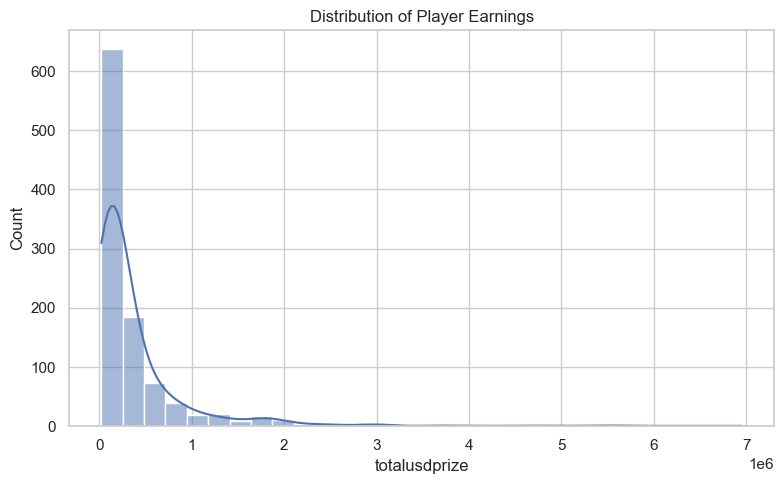

In [19]:
if "totalusdprize" in df_players_merged.columns:
    safe_histplot(df_players_merged, "totalusdprize", "Distribution of Player Earnings")
else:
    print("Column 'totalusdprize' not found in players data.")

Team Earnings & Tournaments Distributions

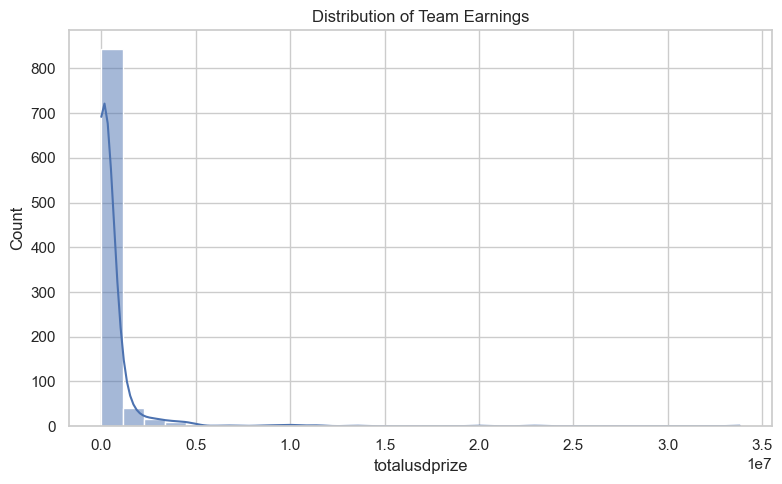

In [20]:
if "totalusdprize" in df_teams.columns:
    safe_histplot(df_teams, "totalusdprize", "Distribution of Team Earnings")
else:
    print("Column 'totalusdprize' not found in teams data.")

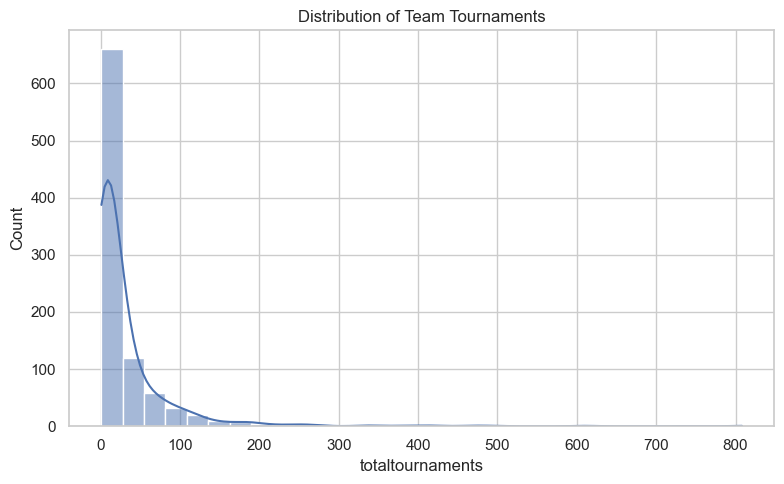

In [21]:
if "totaltournaments" in df_teams.columns:
    safe_histplot(df_teams, "totaltournaments", "Distribution of Team Tournaments")
else:
    print("Column 'totaltournaments' not found in teams data.")

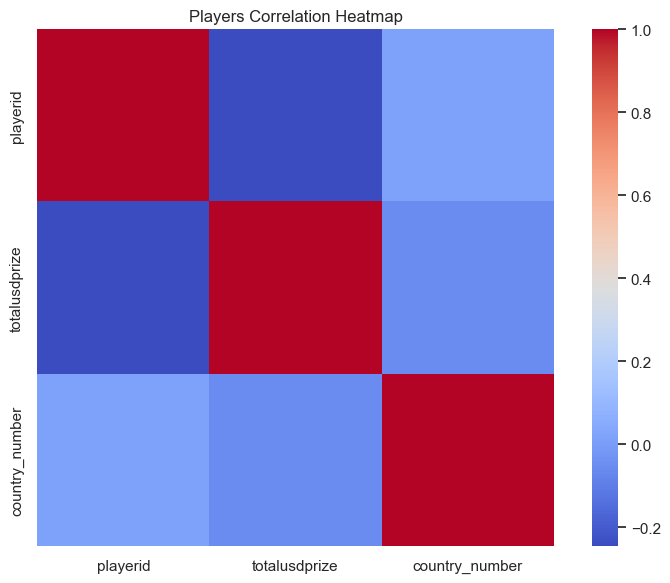

In [22]:
safe_corr_heatmap(df_players_merged, "Players Correlation Heatmap")

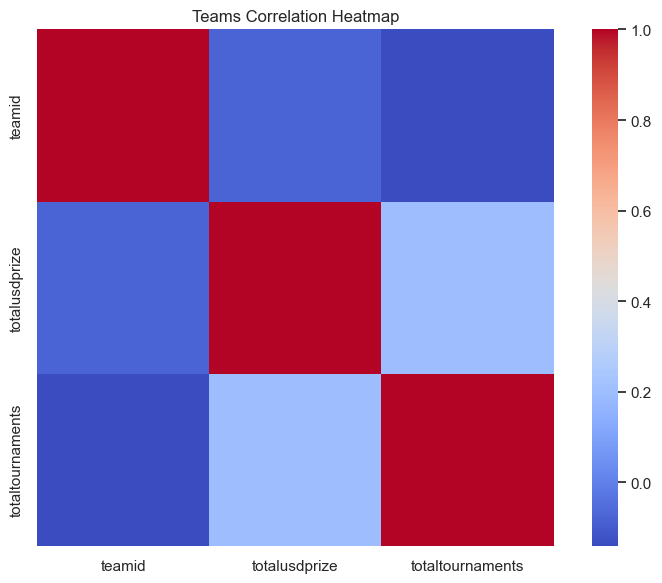

In [23]:
safe_corr_heatmap(df_teams, "Teams Correlation Heatmap")

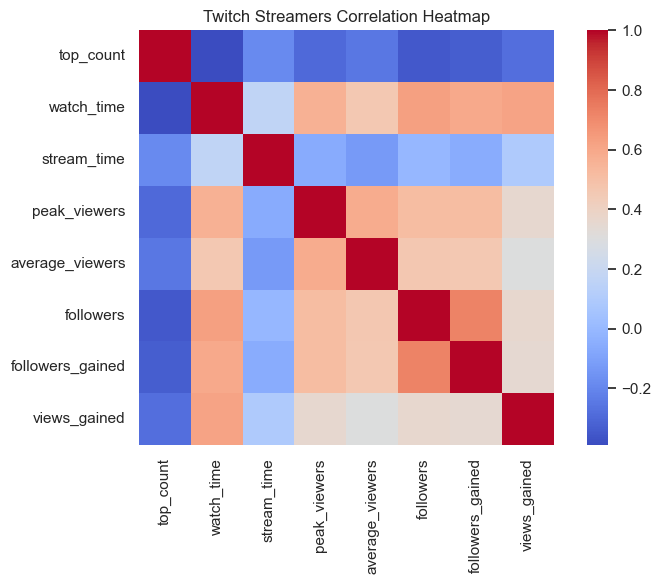

In [24]:
safe_corr_heatmap(df_twitch_streamers, "Twitch Streamers Correlation Heatmap")

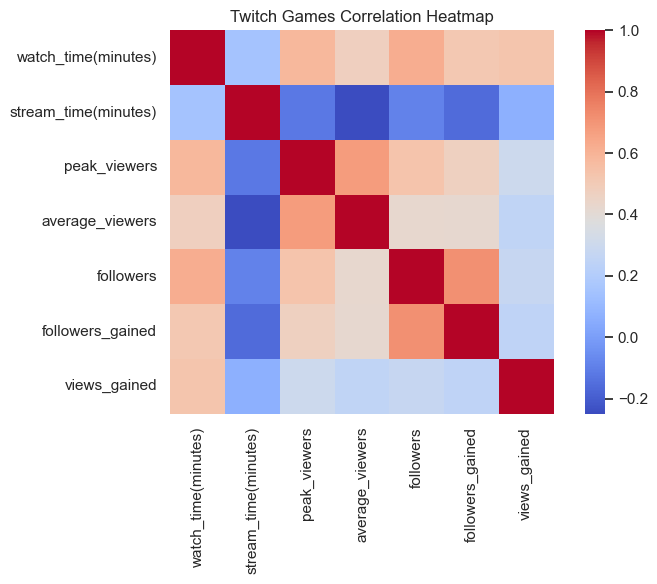

In [25]:
safe_corr_heatmap(df_twitch_games, "Twitch Games Correlation Heatmap")

Top 10 players by earnings

,currenthandle,totalusdprize
currenthandle,,
N0tail,N0tail,6952596.58
JerAx,JerAx,6470000.02
ana,ana,6000411.96
Ceb,Ceb,5554297.41
Topson,Topson,5470902.57
KuroKy,KuroKy,5193382.81
Miracle-,Miracle-,4798043.68
MinD_ContRoL,MinD_ContRoL,4579118.16
GH,GH,4193412.69


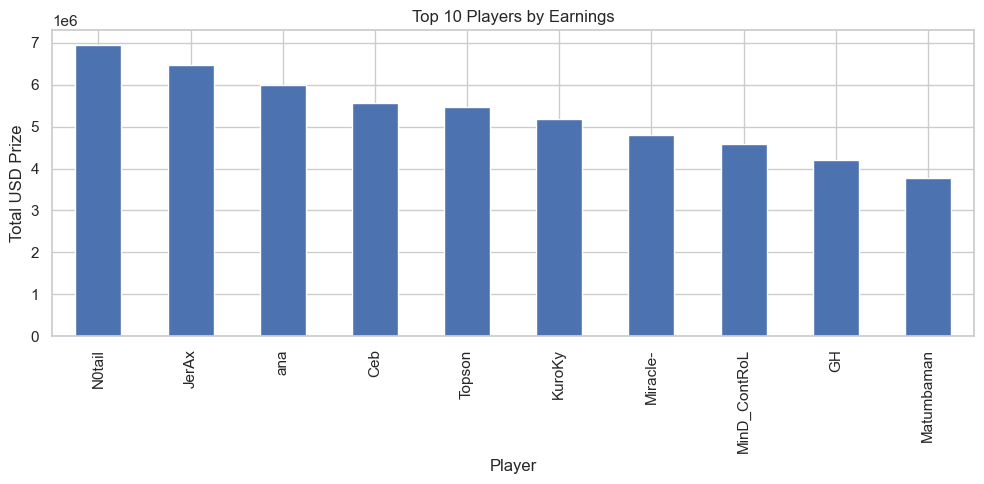

In [26]:
if "totalusdprize" in df_players_merged.columns:
    top_players = (
        df_players_merged.sort_values("totalusdprize", ascending=False)
        .head(10)
        .set_index("currenthandle", drop=False)
    )
    display(top_players[["currenthandle", "totalusdprize"]])
    safe_barplot(
        top_players.set_index("currenthandle")["totalusdprize"],
        title="Top 10 Players by Earnings",
        xlabel="Player",
        ylabel="Total USD Prize",
    )
else:
    print("totalusdprize column missing in players data.")

Top 10 teams by earnings

,totalusdprize
teamname,
OG,33810636.13
Team Liquid,22967431.10
Evil Geniuses,19988670.62
Newbee,13523736.43
Team Secret,11492345.09
Vici Gaming,11182792.92
LGD Gaming,10072755.42
Virtus.pro,10037385.11
Wings Gaming,9739247.35


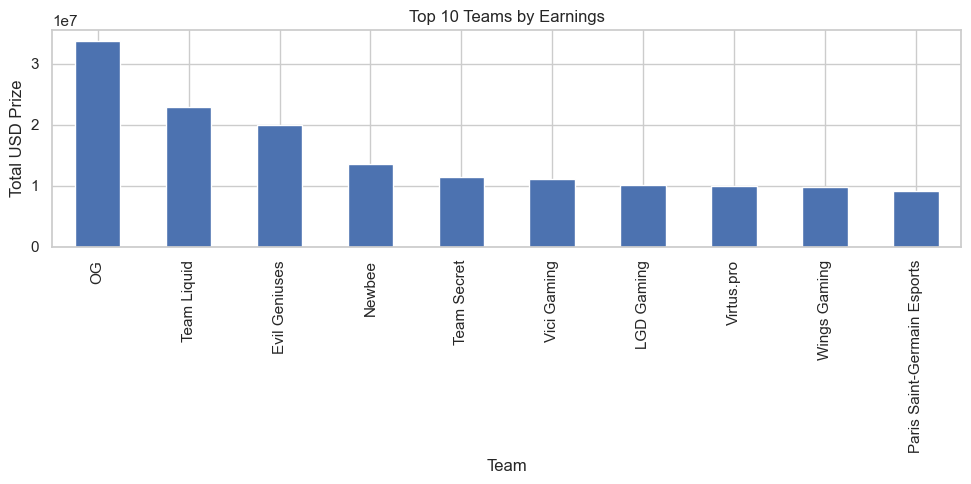

In [27]:
if "totalusdprize" in df_teams.columns and "teamname" in df_teams.columns:
    top_teams = (
        df_teams.sort_values("totalusdprize", ascending=False)
        .head(10)
        .set_index("teamname")
    )
    display(top_teams[["totalusdprize"]])
    safe_barplot(
        top_teams["totalusdprize"],
        title="Top 10 Teams by Earnings",
        xlabel="Team",
        ylabel="Total USD Prize",
    )
else:
    print("Required columns not found in teams data.")

Top 10 countries by total player earnings

country_name
China, People's Republic of     72391878.56
Korea, Republic of              58441733.71
United States of America        43099381.78
Denmark, Kingdom of             26840800.02
Russian Federation              21645785.42
Sweden, Kingdom of              20770423.01
Finland, Republic of            18876262.25
France, French Republic         15803240.18
Canada                          13483648.61
Germany, Federal Republic of    10143181.56
Name: totalusdprize, dtype: float64

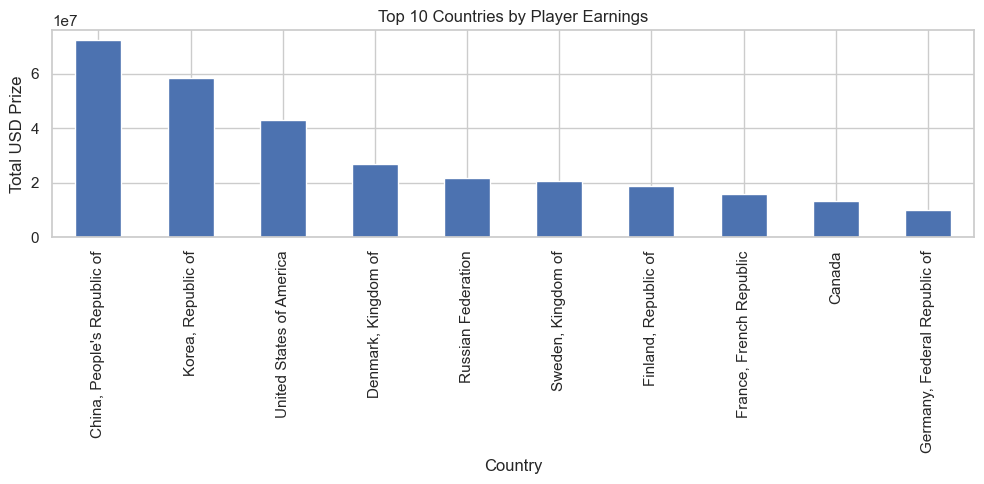

In [28]:
if "country_name" in df_players_merged.columns and "totalusdprize" in df_players_merged.columns:
    country_earnings = (
        df_players_merged.groupby("country_name")["totalusdprize"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    display(country_earnings)
    safe_barplot(
        country_earnings,
        title="Top 10 Countries by Player Earnings",
        xlabel="Country",
        ylabel="Total USD Prize",
    )
else:
    print("country_name or totalusdprize missing in players data.")

Player earnings by continent

continent_name
Asia             1.827135e+08
Europe           1.563520e+08
North America    5.703727e+07
Oceania          7.999675e+06
South America    6.951711e+06
Name: totalusdprize, dtype: float64

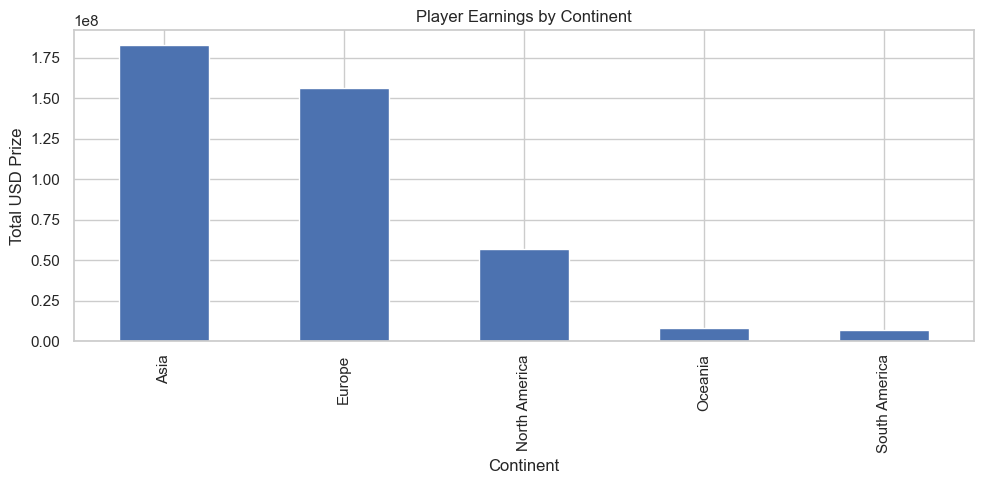

In [29]:
if "continent_name" in df_players_merged.columns and "totalusdprize" in df_players_merged.columns:
    continent_earnings_players = (
        df_players_merged.groupby("continent_name")["totalusdprize"].sum().sort_values(ascending=False)
    )
    display(continent_earnings_players)
    safe_barplot(
        continent_earnings_players,
        title="Player Earnings by Continent",
        xlabel="Continent",
        ylabel="Total USD Prize",
    )
else:
    print("continent_name or totalusdprize missing in players data.")

Top games by earnings (players)

game
Dota 2                              1.857838e+08
Counter-Strike: Global Offensive    6.084354e+07
Fortnite                            4.396542e+07
League of Legends                   3.504348e+07
Starcraft II                        2.537982e+07
Hearthstone                         1.420638e+07
PUBG                                1.330559e+07
Overwatch                           1.241176e+07
Heroes of the Storm                 1.178045e+07
Arena of Valor                      8.333952e+06
Name: totalusdprize, dtype: float64

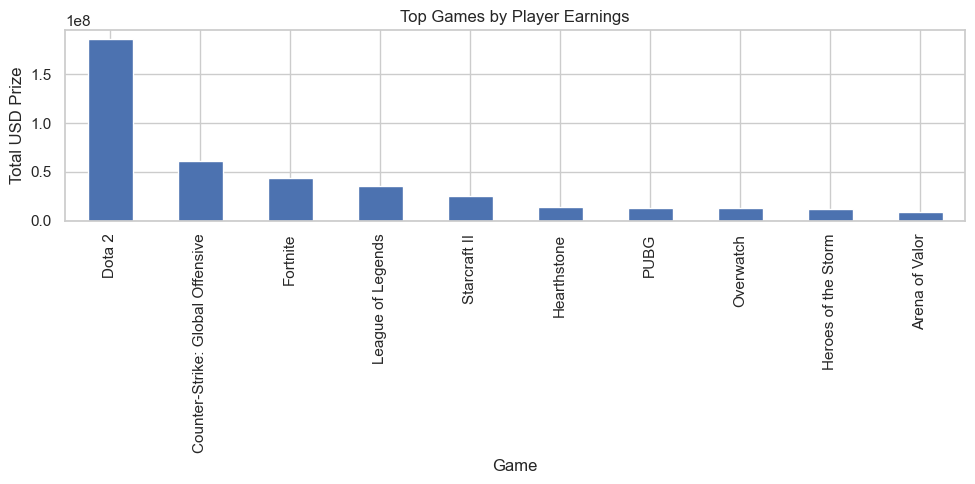

In [30]:
if "game" in df_players_merged.columns and "totalusdprize" in df_players_merged.columns:
    game_earnings_players = (
        df_players_merged.groupby("game")["totalusdprize"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    display(game_earnings_players)
    safe_barplot(
        game_earnings_players,
        title="Top Games by Player Earnings",
        xlabel="Game",
        ylabel="Total USD Prize",
    )
else:
    print("game or totalusdprize missing in players data.")

Top games by earnings (teams)

game
Dota 2                              2.202828e+08
Counter-Strike: Global Offensive    8.485393e+07
League of Legends                   6.466556e+07
Fortnite                            3.466133e+07
Starcraft II                        2.785615e+07
Overwatch                           2.046527e+07
PUBG                                1.671500e+07
Hearthstone                         1.086453e+07
Heroes of the Storm                 1.071052e+07
Arena of Valor                      9.969149e+06
Name: totalusdprize, dtype: float64

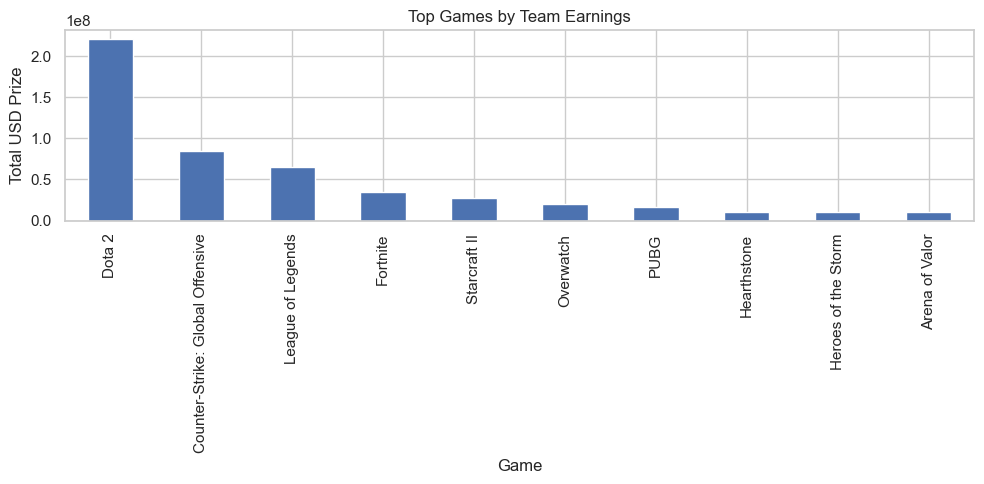

In [31]:
if "game" in df_teams.columns and "totalusdprize" in df_teams.columns:
    game_earnings_teams = (
        df_teams.groupby("game")["totalusdprize"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    display(game_earnings_teams)
    safe_barplot(
        game_earnings_teams,
        title="Top Games by Team Earnings",
        xlabel="Game",
        ylabel="Total USD Prize",
    )
else:
    print("game or totalusdprize missing in teams data.")

Earnings by genre (players & teams)

genre
Multiplayer Online Battle Arena    2.409416e+08
First-Person Shooter               7.325530e+07
Battle Royale                      5.727101e+07
Strategy                           2.537982e+07
Collectible Card Game              1.420638e+07
Name: totalusdprize, dtype: float64

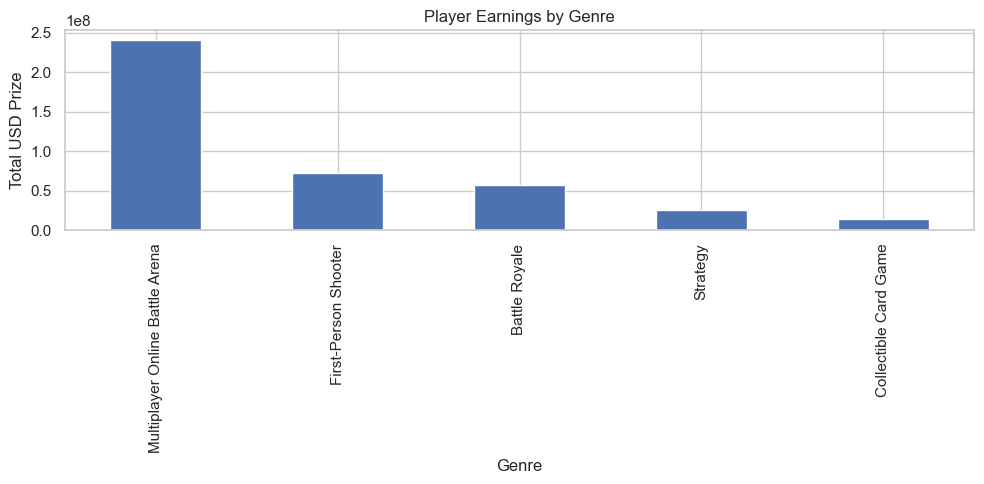

In [32]:
if "genre" in df_players_merged.columns and "totalusdprize" in df_players_merged.columns:
    genre_players = (
        df_players_merged.groupby("genre")["totalusdprize"]
        .sum()
        .sort_values(ascending=False)
    )
    display(genre_players.head(10))
    safe_barplot(
        genre_players.head(15),
        title="Player Earnings by Genre",
        xlabel="Genre",
        ylabel="Total USD Prize",
    )
else:
    print("genre or totalusdprize missing in players data.")

genre
Multiplayer Online Battle Arena    3.056280e+08
First-Person Shooter               1.053192e+08
Battle Royale                      5.137633e+07
Strategy                           2.785615e+07
Collectible Card Game              1.086453e+07
Name: totalusdprize, dtype: float64

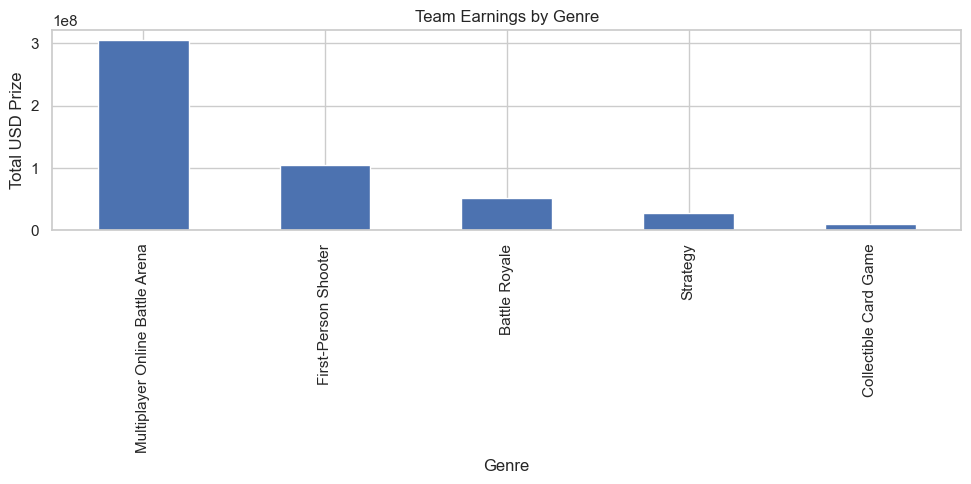

In [33]:
if "genre" in df_teams.columns and "totalusdprize" in df_teams.columns:
    genre_teams = (
        df_teams.groupby("genre")["totalusdprize"]
        .sum()
        .sort_values(ascending=False)
    )
    display(genre_teams.head(10))
    safe_barplot(
        genre_teams.head(15),
        title="Team Earnings by Genre",
        xlabel="Genre",
        ylabel="Total USD Prize",
    )
else:
    print("genre or totalusdprize missing in teams data.")

#### Twitch Streamer Analysis – Column Detection

In [34]:
twitch_streamer_cols = get_twitch_streamer_columns(df_twitch_streamers)
twitch_streamer_cols

{'name': 'screen_name',
 'followers': 'followers',
 'avg_viewers': 'average_viewers',
 'peak_viewers': 'peak_viewers',
 'hours_watched': 'watch_time',
 'partner': 'partnered'}

Followers & Average Viewers Distributions

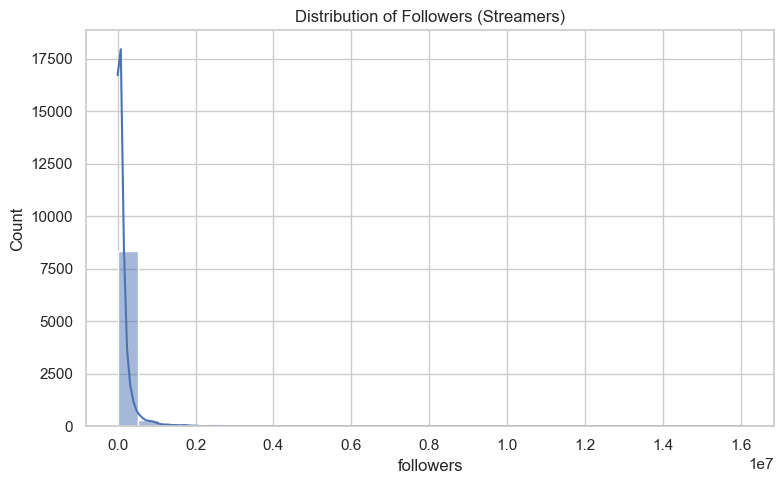

In [35]:
followers_col = twitch_streamer_cols["followers"]
avg_viewers_col = twitch_streamer_cols["avg_viewers"]

if followers_col:
    safe_histplot(df_twitch_streamers, followers_col, "Distribution of Followers (Streamers)")
else:
    print("Followers column not detected for streamers.")

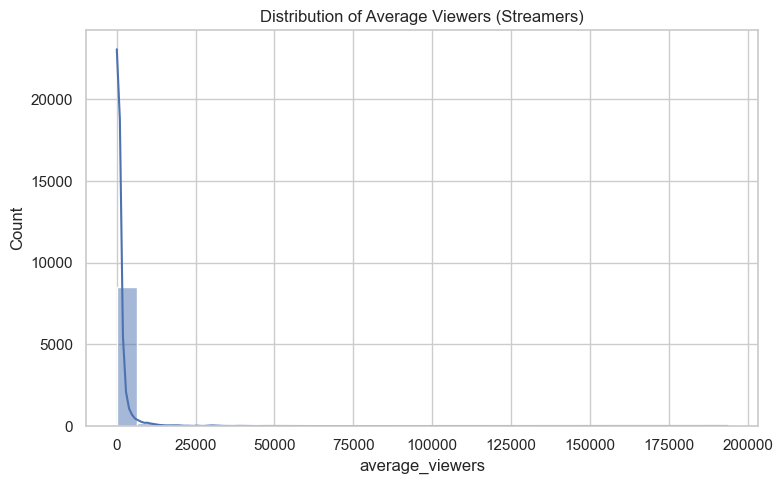

In [36]:
if avg_viewers_col:
    safe_histplot(df_twitch_streamers, avg_viewers_col, "Distribution of Average Viewers (Streamers)")
else:
    print("Average viewers column not detected for streamers.")

Partner vs Non-Partner Boxplot (Average Viewers)

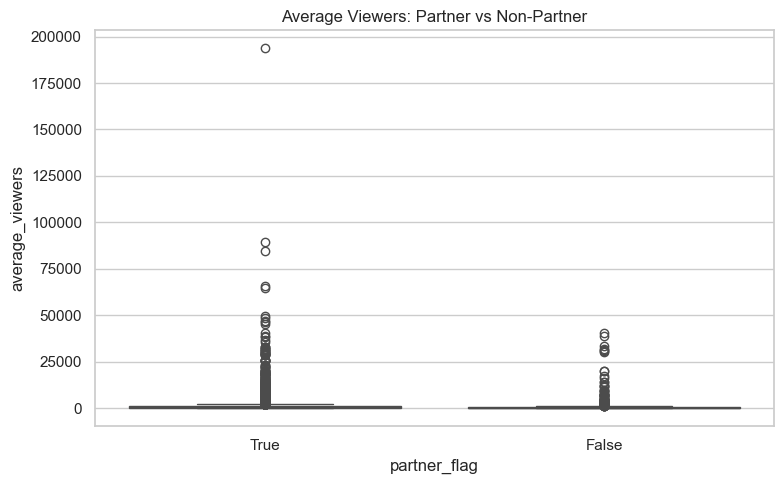

In [37]:
partner_col = twitch_streamer_cols["partner"]

if partner_col and avg_viewers_col:
    # Attempt to standardize partner flag to categorical
    df_twitch_streamers["partner_flag"] = df_twitch_streamers[partner_col].astype(str)
    safe_boxplot(
        df_twitch_streamers,
        x="partner_flag",
        y=avg_viewers_col,
        title="Average Viewers: Partner vs Non-Partner",
    )
else:
    print("Partner or avg_viewers column missing for streamers.")

#### Twitch Game Analysis – Column Detection

In [38]:
twitch_game_cols = get_twitch_game_columns(df_twitch_games)
twitch_game_cols

[get_twitch_game_columns] Falling back to non-numeric column 'channel' as game/category name.


{'game': 'channel',
 'avg_viewers': 'average_viewers',
 'peak_viewers': 'peak_viewers',
 'hours_watched': 'watch_time(minutes)'}

Top 15 Games by Hours Watched

Detected game column: channel
Detected hours_watched column: watch_time(minutes)


channel
xQcOW                     6196161750
summit1g                  6091677300
Gaules                    5644590915
ESL_CSGO                  3970318140
Tfue                      3671000070
Asmongold                 3668799075
NICKMERCS                 3360675195
Fextralife                3301867485
loltyler1                 2928356940
Anomaly                   2865429915
TimTheTatman              2834436990
LIRIK                     2832930285
Riot Games (riotgames)    2674646715
Rubius                    2588632635
auronplay                 2410022550
Name: watch_time(minutes), dtype: int64

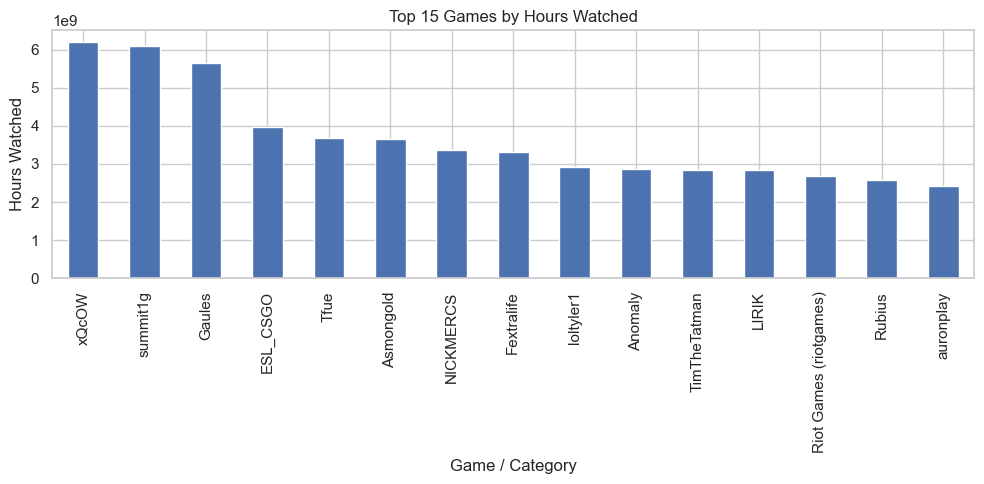

In [39]:
game_col = twitch_game_cols["game"]
hours_col = twitch_game_cols["hours_watched"]

print("Detected game column:", game_col)
print("Detected hours_watched column:", hours_col)

if hours_col:
    # If still no game/category column, treat everything as a single group
    if not game_col:
        df_tmp = df_twitch_games.copy()
        df_tmp["_game_dummy"] = "All Games"
        game_col = "_game_dummy"
    else:
        df_tmp = df_twitch_games.copy()

    top_games_hours = (
        df_tmp.groupby(game_col)[hours_col]
        .sum()
        .sort_values(ascending=False)
        .head(15)
    )
    display(top_games_hours)
    safe_barplot(
        top_games_hours,
        title="Top 15 Games by Hours Watched",
        xlabel="Game / Category",
        ylabel="Hours Watched",
    )
else:
    print("Hours_watched column not available for twitch games.")

Scatter: Average vs Peak Viewers

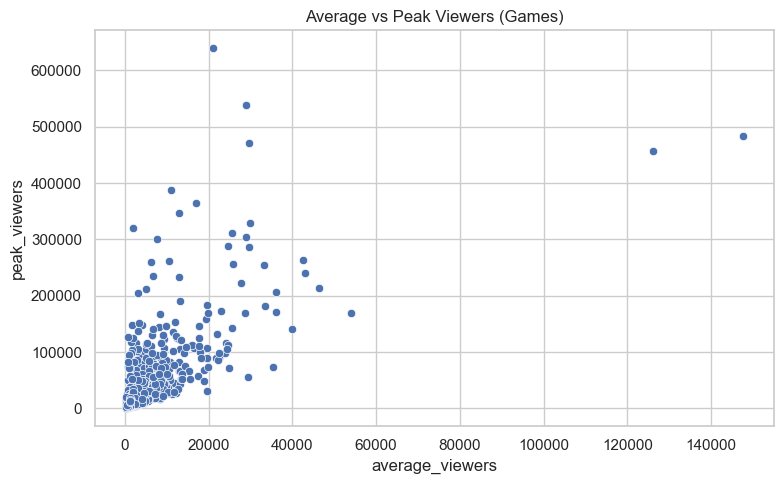

In [40]:
avg_viewers_games_col = twitch_game_cols["avg_viewers"]
peak_viewers_games_col = twitch_game_cols["peak_viewers"]

if avg_viewers_games_col and peak_viewers_games_col:
    safe_scatter(
        df_twitch_games,
        x=avg_viewers_games_col,
        y=peak_viewers_games_col,
        title="Average vs Peak Viewers (Games)",
    )
else:
    print("Average/peak viewers columns not available for twitch games.")

#### Esports Growth Analysis (2020–2025)

In [41]:
growth_cols = get_growth_columns(df_growth)
growth_cols

{'year': 'year',
 'revenue': 'gaming_revenue_billionusd',
 'audience': 'esports_viewers_million',
 'region': 'region'}

In [42]:
year_col = growth_cols["year"]
revenue_col = growth_cols["revenue"]
audience_col = growth_cols["audience"]
region_col = growth_cols["region"]

if year_col is None:
    raise KeyError("Year column could not be detected in growth data.")

df_growth[year_col] = pd.to_numeric(df_growth[year_col], errors="coerce")
df_growth_years = df_growth.dropna(subset=[year_col])

df_growth_2020_2025 = df_growth_years[
    (df_growth_years[year_col] >= 2020) & (df_growth_years[year_col] <= 2025)
].copy()

df_growth_2020_2025.sort_values(year_col, inplace=True)
df_growth_2020_2025.head()

,year,country,region,gaming_revenue_billionusd,esports_revenue_millionusd,active_players_million,esports_viewers_million,avg_spending_usd,top_genre,top_platform,...,pro_players_count,internet_penetration_percent,avg_latency_ms,ar_vr_adoption_index,streaming_influence_index,covid_impact_index,female_gamer_percent,mobile_gaming_share,esports_prizepool_millionusd,gaming_companies_count
10,2020,United States,North America,53.72,4133.4,16.2,29.7,56.3,FPS,Mobile,...,25944,93.3,43.9,0.60,1.11,0.41,26.4,50.0,23.1,395
26,2020,China,Asia,40.36,3415.4,29.0,81.0,35.8,MOBA,Mobile,...,10877,92.0,62.6,0.53,1.04,0.34,27.9,50.0,11.8,334
42,2020,Japan,Asia,45.82,3549.6,14.0,45.7,120.8,MOBA,Mobile,...,5358,73.4,82.9,0.47,1.00,0.30,25.1,50.0,8.3,388
58,2020,South Korea,Asia,75.86,10922.0,38.4,83.3,46.7,Sports,Mobile,...,3040,90.2,84.1,0.46,1.26,0.56,27.2,50.0,5.8,47
74,2020,Germany,Europe,58.19,7786.5,25.5,77.4,80.6,RPG,PC,...,618,77.1,43.4,0.64,1.15,0.45,26.2,50.0,2.0,158


Revenue & Audience Trends

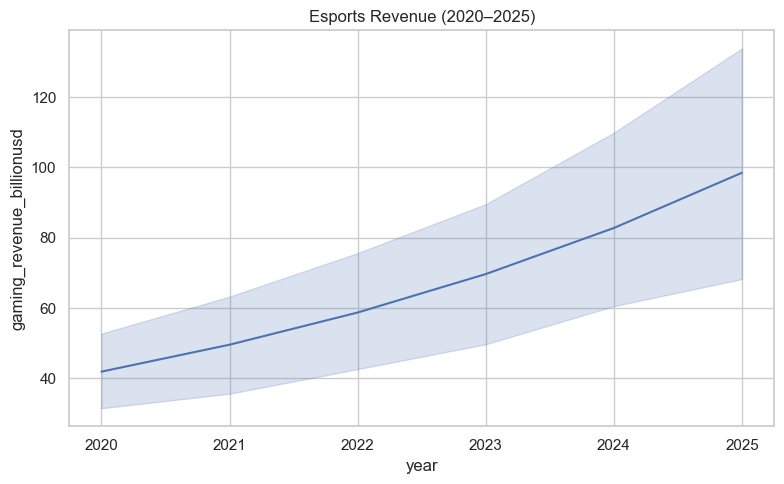

In [43]:
if revenue_col:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_growth_2020_2025, x=year_col, y=revenue_col)
    plt.title("Esports Revenue (2020–2025)")
    plt.tight_layout()
    plt.show()
else:
    print("Revenue column not detected in growth data.")

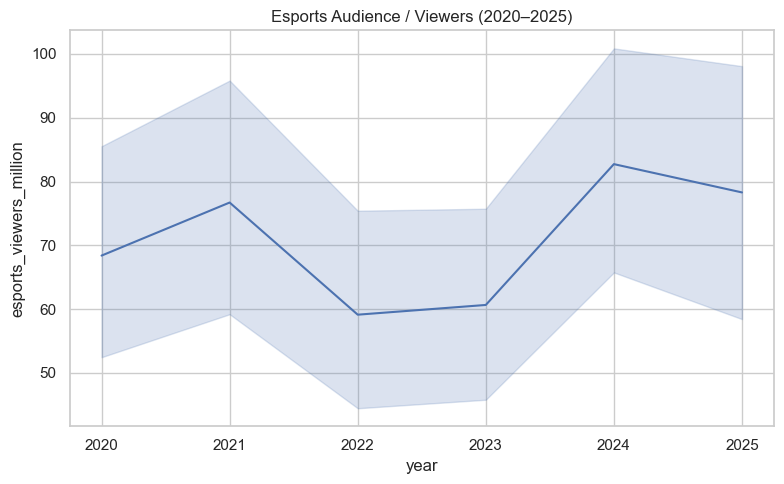

In [44]:
if audience_col:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_growth_2020_2025, x=year_col, y=audience_col)
    plt.title("Esports Audience / Viewers (2020–2025)")
    plt.tight_layout()
    plt.show()
else:
    print("Audience column not detected in growth data.")

CAGR Calculations (Revenue & Audience)

In [45]:
def compute_cagr(series: pd.Series):
    series = ensure_numeric_series(series.dropna())
    if series.empty or len(series) < 2:
        return np.nan
    first = series.iloc[0]
    last = series.iloc[-1]
    n_periods = len(series) - 1
    if first <= 0:
        return np.nan
    return (last / first) ** (1 / n_periods) - 1


revenue_cagr = compute_cagr(df_growth_2020_2025[revenue_col]) if revenue_col else np.nan
audience_cagr = compute_cagr(df_growth_2020_2025[audience_col]) if audience_col else np.nan

print(f"Revenue CAGR (2020–2025): {revenue_cagr:.2%}" if not np.isnan(revenue_cagr) else "Revenue CAGR: N/A")
print(f"Audience CAGR (2020–2025): {audience_cagr:.2%}" if not np.isnan(audience_cagr) else "Audience CAGR: N/A")

Revenue CAGR (2020–2025): 0.30%
Audience CAGR (2020–2025): 0.87%


Regional Trends (if available)

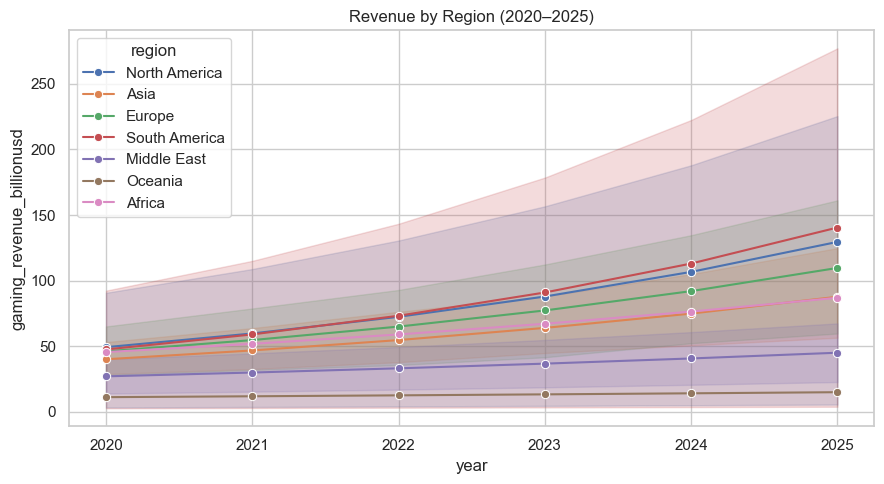

In [46]:
if region_col and revenue_col:
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=df_growth_2020_2025,
        x=year_col,
        y=revenue_col,
        hue=region_col,
        marker="o",
    )
    plt.title("Revenue by Region (2020–2025)")
    plt.tight_layout()
    plt.show()
else:
    print("Region or revenue column not available for regional revenue trends.")

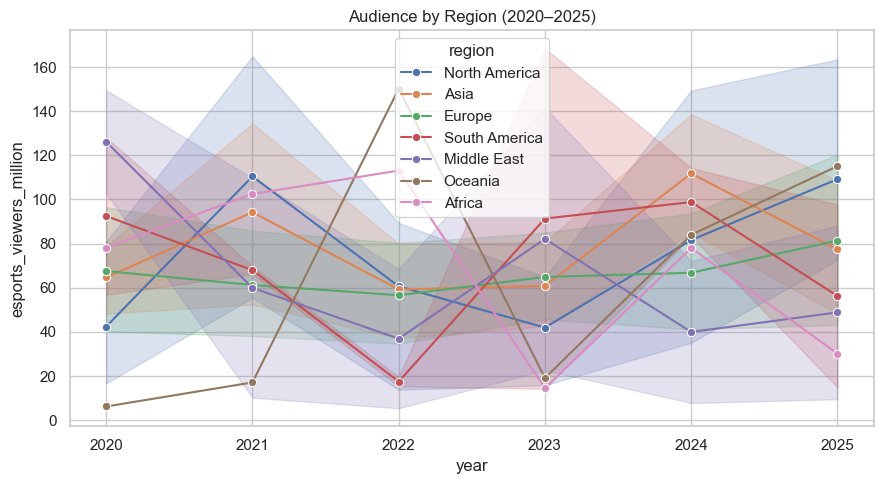

In [47]:
if region_col and audience_col:
    plt.figure(figsize=(9, 5))
    sns.lineplot(
        data=df_growth_2020_2025,
        x=year_col,
        y=audience_col,
        hue=region_col,
        marker="o",
    )
    plt.title("Audience by Region (2020–2025)")
    plt.tight_layout()
    plt.show()
else:
    print("Region or audience column not available for regional audience trends.")

#### Player & Team Performance Analysis

Continent dominance (player earnings)

Continent share of total player earnings (%):


continent_name
Asia             44.449993
Europe           38.036827
North America    13.875853
Oceania           1.946136
South America     1.691191
Name: totalusdprize, dtype: float64

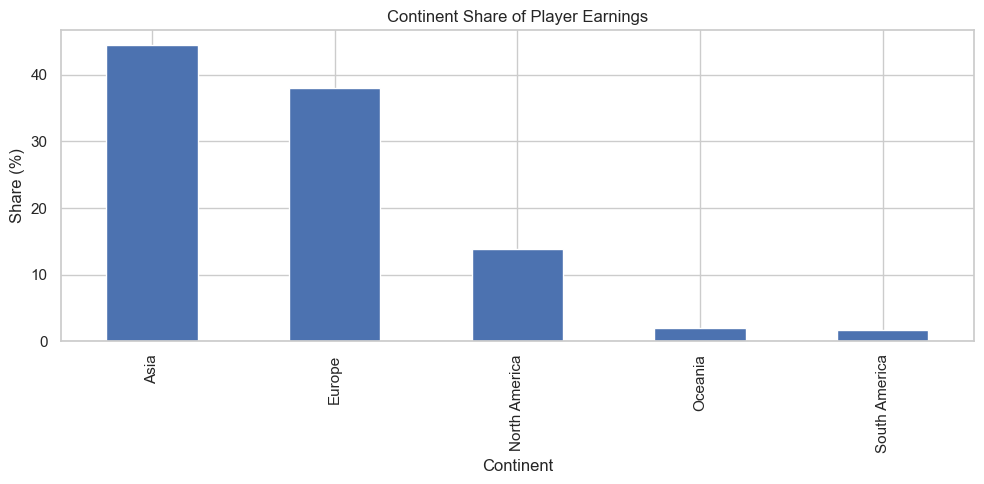

In [48]:
if "continent_name" in df_players_merged.columns and "totalusdprize" in df_players_merged.columns:
    continent_totals = df_players_merged.groupby("continent_name")["totalusdprize"].sum()
    total_earnings = continent_totals.sum()
    continent_share = (continent_totals / total_earnings * 100).sort_values(ascending=False)
    print("Continent share of total player earnings (%):")
    display(continent_share)
    safe_barplot(
        continent_share,
        title="Continent Share of Player Earnings",
        xlabel="Continent",
        ylabel="Share (%)",
    )
else:
    print("Missing continent_name or totalusdprize in players data for continent dominance.")

Earnings inequality (players)

Player earnings skewness: 4.839266816565894
Player earnings kurtosis: 31.0900510153921


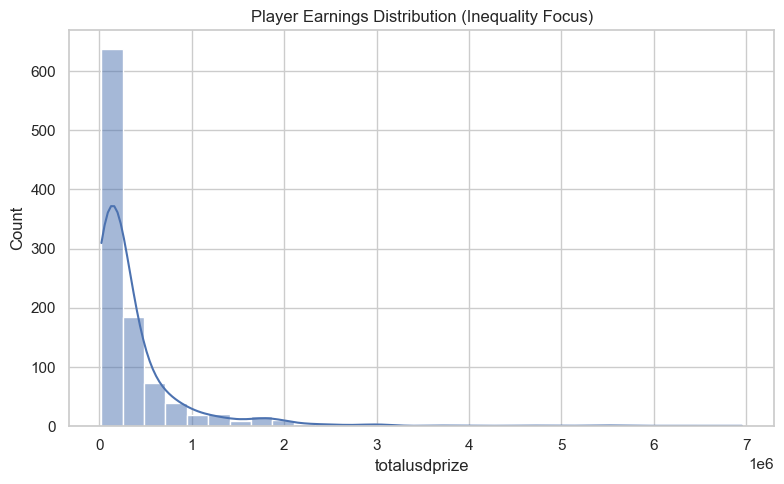

In [49]:
if "totalusdprize" in df_players_merged.columns:
    players_earnings = ensure_numeric_series(df_players_merged["totalusdprize"]).dropna()
    print("Player earnings skewness:", skew(players_earnings))
    print("Player earnings kurtosis:", kurtosis(players_earnings))
    safe_histplot(df_players_merged, "totalusdprize", "Player Earnings Distribution (Inequality Focus)")
else:
    print("totalusdprize missing in players data for inequality analysis.")

Earnings inequality (teams)

Team earnings skewness: 10.229354328121637
Team earnings kurtosis: 138.52216418647362


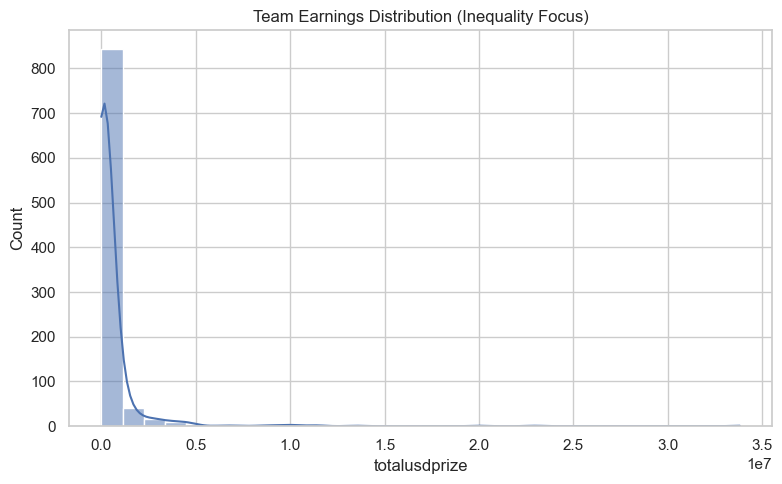

In [50]:
if "totalusdprize" in df_teams.columns:
    teams_earnings = ensure_numeric_series(df_teams["totalusdprize"]).dropna()
    print("Team earnings skewness:", skew(teams_earnings))
    print("Team earnings kurtosis:", kurtosis(teams_earnings))
    safe_histplot(df_teams, "totalusdprize", "Team Earnings Distribution (Inequality Focus)")
else:
    print("totalusdprize missing in teams data for inequality analysis.")

Twitch Streamer Analysis (Deeper)

In [51]:
followers_col = twitch_streamer_cols["followers"]
avg_viewers_col = twitch_streamer_cols["avg_viewers"]
hours_watched_streamers_col = twitch_streamer_cols["hours_watched"]

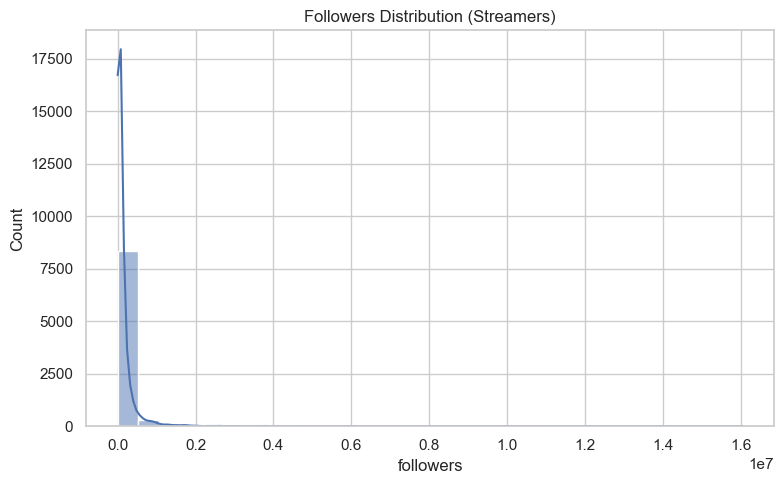

In [52]:
if followers_col:
    safe_histplot(df_twitch_streamers, followers_col, "Followers Distribution (Streamers)")

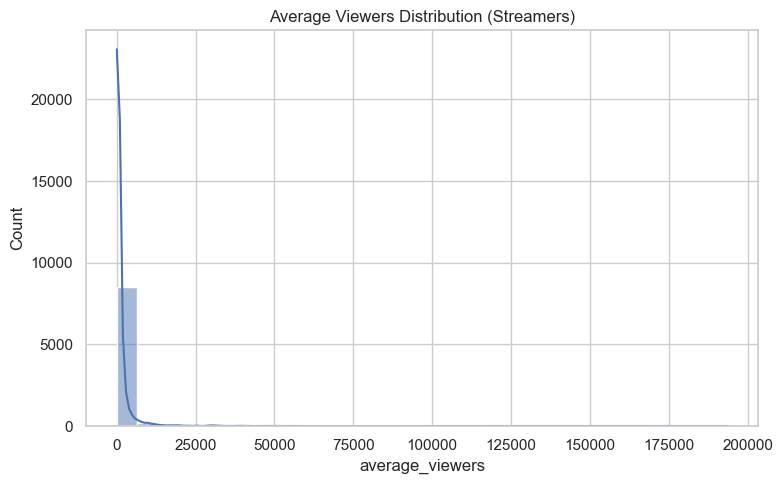

In [53]:
if avg_viewers_col:
    safe_histplot(df_twitch_streamers, avg_viewers_col, "Average Viewers Distribution (Streamers)")

Partner vs Non-Partner – t-test on Average Viewers

In [54]:
if partner_col and avg_viewers_col:
    df_twitch_streamers["partner_flag"] = df_twitch_streamers[partner_col].astype(str)
    partners = ensure_numeric_series(
        df_twitch_streamers.loc[df_twitch_streamers["partner_flag"].str.lower().isin(["true", "yes", "1", "partner"]), avg_viewers_col]
    ).dropna()
    non_partners = ensure_numeric_series(
        df_twitch_streamers.loc[~df_twitch_streamers["partner_flag"].str.lower().isin(["true", "yes", "1", "partner"]), avg_viewers_col]
    ).dropna()

    if len(partners) > 5 and len(non_partners) > 5:
        t_stat, p_val = ttest_ind(partners, non_partners, equal_var=False)
        print(f"Welch t-test (avg viewers: partner vs non-partner)")
        print(f"t-statistic = {t_stat:.3f}, p-value = {p_val:.3g}")
    else:
        print("Not enough data points for t-test on partner vs non-partner.")
else:
    print("Partner or avg_viewers columns missing for t-test.")

Welch t-test (avg viewers: partner vs non-partner)
t-statistic = 2.164, p-value = 0.0306


#### Top Creators & Category Concentration

Top streamers by hours watched

screen_name
xQcOW                     7333609065
Gaules                    6314532585
summit1g                  6235007490
ESL_CSGO                  4764929775
NICKMERCS                 3853252845
Fextralife                3644124975
loltyler1                 3503191680
Rubius                    3278317200
Tfue                      3276339360
auronplay                 3268219170
TimTheTatman              3183232095
LIRIK                     3081007830
Anomaly                   2858427090
Asmongold                 2808614685
Riot Games (riotgames)    2730387960
Name: watch_time, dtype: int64

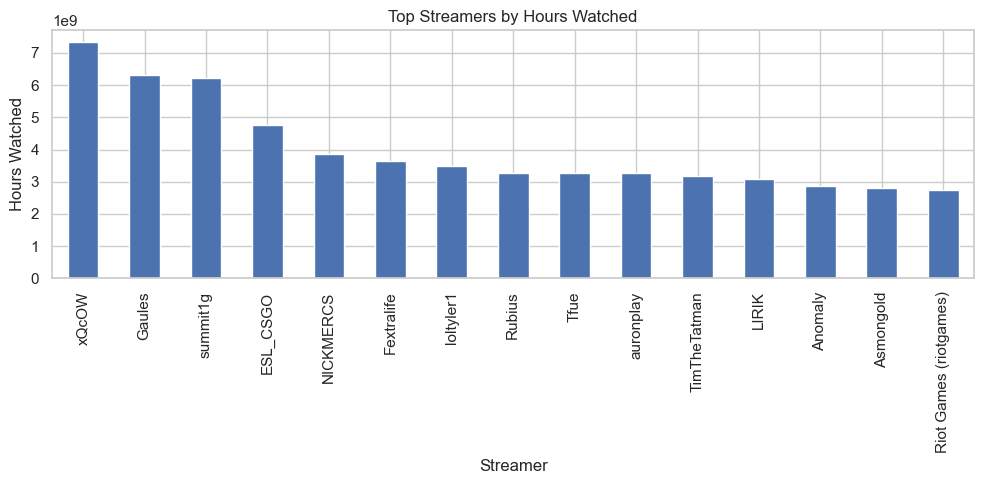

In [55]:
if hours_watched_streamers_col and twitch_streamer_cols["name"]:
    top_streamers_hours = (
        df_twitch_streamers.groupby(twitch_streamer_cols["name"])[hours_watched_streamers_col]
        .sum()
        .sort_values(ascending=False)
        .head(15)
    )
    display(top_streamers_hours)
    safe_barplot(
        top_streamers_hours,
        title="Top Streamers by Hours Watched",
        xlabel="Streamer",
        ylabel="Hours Watched",
    )
else:
    print("Need name and hours_watched columns for top creators analysis.")

Top streamers by followers

screen_name
Ninja                     16042584
Tfue                       9184421
shroud                     8341579
Myth                       6972015
Rubius                     6579492
pokimane                   5954547
TimTheTatman               5639554
summit1g                   5374710
auronplay                  5053692
Riot Games (riotgames)     4895737
dakotaz                    4635951
TheGrefg                   4475337
DrDisrespect               4450718
NICKMERCS                  4415637
DrLupo                     4317101
Name: followers, dtype: int64

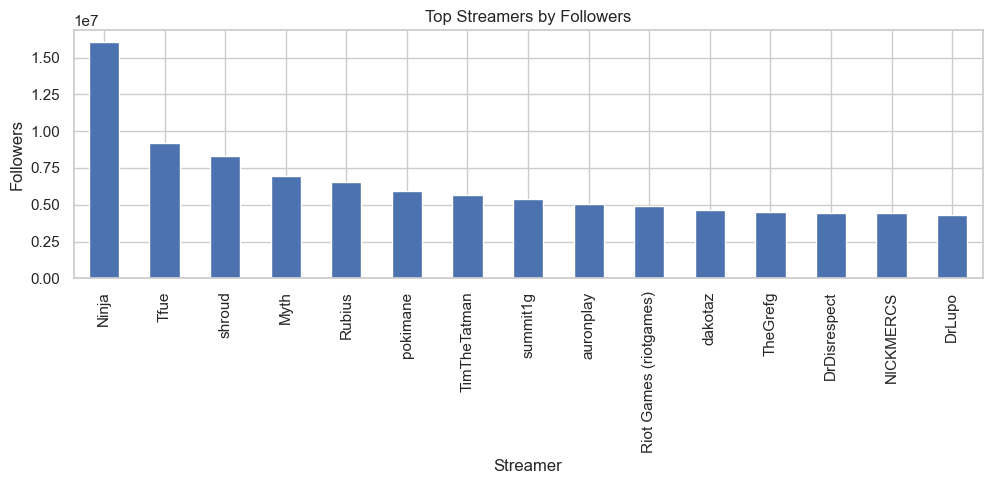

In [56]:
if followers_col and twitch_streamer_cols["name"]:
    top_streamers_followers = (
        df_twitch_streamers.groupby(twitch_streamer_cols["name"])[followers_col]
        .max()
        .sort_values(ascending=False)
        .head(15)
    )
    display(top_streamers_followers)
    safe_barplot(
        top_streamers_followers,
        title="Top Streamers by Followers",
        xlabel="Streamer",
        ylabel="Followers",
    )
else:
    print("Need name and followers columns for follower ranking.")

Category concentration by hours watched

channel
xQcOW                     6196161750
summit1g                  6091677300
Gaules                    5644590915
ESL_CSGO                  3970318140
Tfue                      3671000070
Asmongold                 3668799075
NICKMERCS                 3360675195
Fextralife                3301867485
loltyler1                 2928356940
Anomaly                   2865429915
TimTheTatman              2834436990
LIRIK                     2832930285
Riot Games (riotgames)    2674646715
Rubius                    2588632635
auronplay                 2410022550
Name: watch_time(minutes), dtype: int64

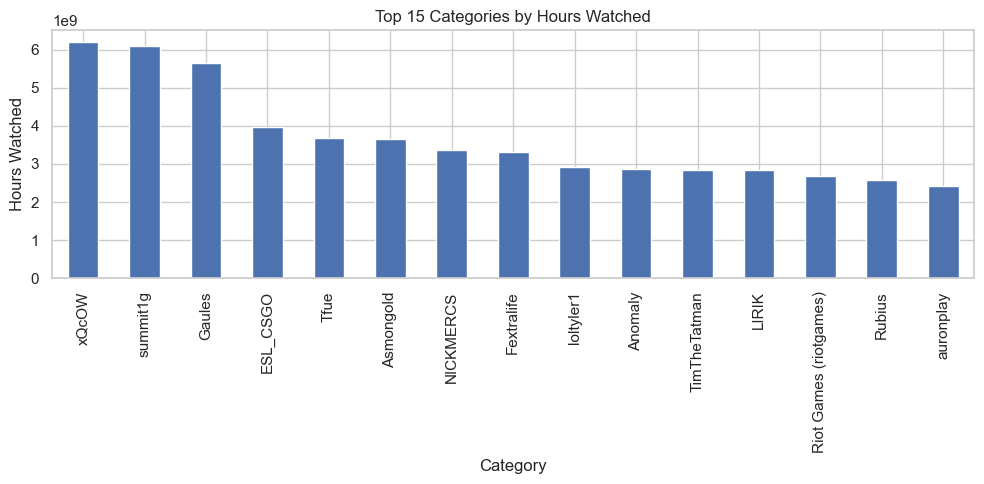

In [57]:
if game_col and hours_col:
    category_hours = (
        df_twitch_games.groupby(game_col)[hours_col]
        .sum()
        .sort_values(ascending=False)
        .head(15)
    )
    display(category_hours)
    safe_barplot(
        category_hours,
        title="Top 15 Categories by Hours Watched",
        xlabel="Category",
        ylabel="Hours Watched",
    )
else:
    print("Game or hours_watched column missing for category concentration.")

Outlier Detection (Average Viewers)

In [58]:
if avg_viewers_col:
    df_twitch_streamers["avg_viewers_numeric"] = ensure_numeric_series(df_twitch_streamers[avg_viewers_col])
    df_twitch_streamers["avg_viewers_z"] = zscore(df_twitch_streamers["avg_viewers_numeric"].fillna(0))
    outliers = df_twitch_streamers[np.abs(df_twitch_streamers["avg_viewers_z"]) > 3]
    print(f"Number of streamers with |z| > 3 (avg viewers): {len(outliers)}")
else:
    print("Average viewers column not available for outlier detection.")

Number of streamers with |z| > 3 (avg viewers): 104


#### Twitch Game-Level Popularity Analysis

Popularity Tiers based on Hours Watched

In [59]:
hours_col = twitch_game_cols["hours_watched"]

if hours_col:
    df_twitch_games["hours_numeric"] = ensure_numeric_series(df_twitch_games[hours_col])
    q1 = df_twitch_games["hours_numeric"].quantile(0.33)
    q2 = df_twitch_games["hours_numeric"].quantile(0.66)

    def assign_popularity_tier(x):
        if pd.isna(x):
            return "Unknown"
        if x <= q1:
            return "Low"
        elif x <= q2:
            return "Medium"
        else:
            return "High"

    df_twitch_games["popularity_tier"] = df_twitch_games["hours_numeric"].apply(assign_popularity_tier)
    df_twitch_games["popularity_tier"].value_counts()
else:
    print("Hours watched column unavailable – cannot compute popularity tiers.")

Barplot of tier counts

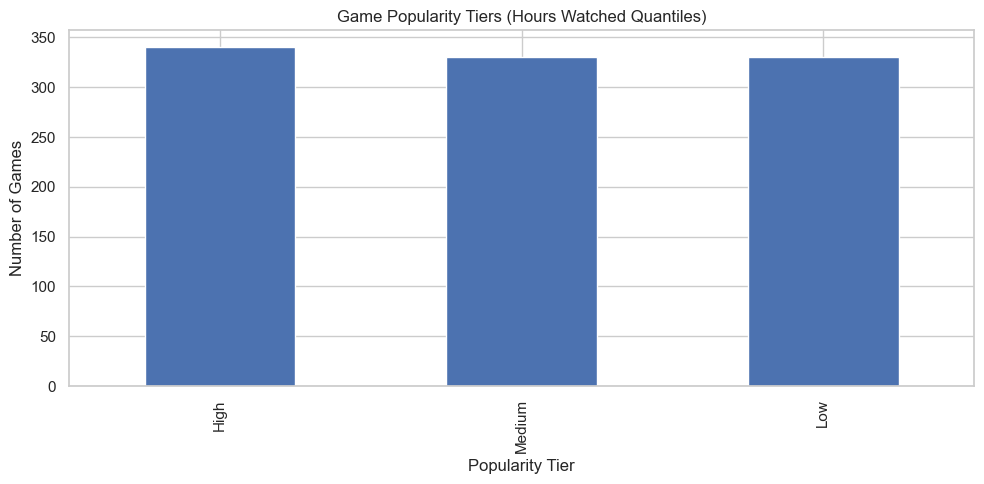

In [60]:
if "popularity_tier" in df_twitch_games.columns:
    tier_counts = df_twitch_games["popularity_tier"].value_counts()
    safe_barplot(
        tier_counts,
        title="Game Popularity Tiers (Hours Watched Quantiles)",
        xlabel="Popularity Tier",
        ylabel="Number of Games",
    )

Advanced Stats & Distribution Checks (Hours Watched)

Hours watched stats:
Mean: 418427930.13
Median: 234990787.5
Variance: 3.02099198341618e+17
Skewness: 5.1581433426119245
Kurtosis: 38.235197446772425


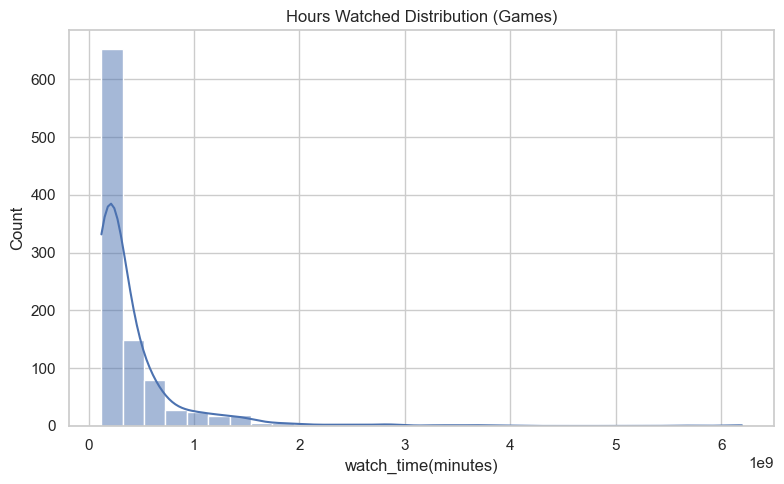

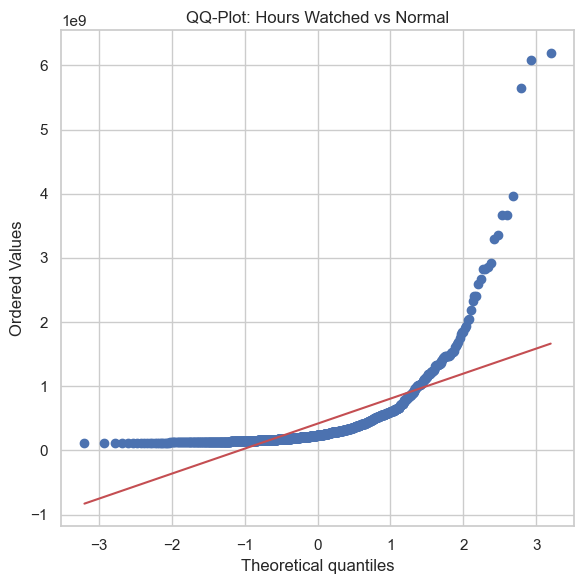

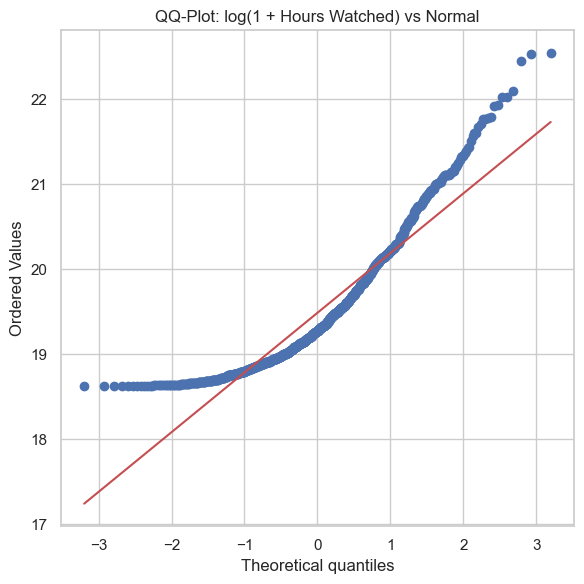

In [61]:
if hours_col:
    hours_series = ensure_numeric_series(df_twitch_games[hours_col]).dropna()
    print("Hours watched stats:")
    print("Mean:", hours_series.mean())
    print("Median:", hours_series.median())
    print("Variance:", hours_series.var())
    print("Skewness:", skew(hours_series))
    print("Kurtosis:", kurtosis(hours_series))

    safe_histplot(df_twitch_games, hours_col, "Hours Watched Distribution (Games)")

    # QQ-plot vs normal
    plt.figure(figsize=(6, 6))
    probplot(hours_series, dist="norm", plot=plt)
    plt.title("QQ-Plot: Hours Watched vs Normal")
    plt.tight_layout()
    plt.show()

    # Log-transformed QQ-plot
    log_hours = np.log1p(hours_series)
    plt.figure(figsize=(6, 6))
    probplot(log_hours, dist="norm", plot=plt)
    plt.title("QQ-Plot: log(1 + Hours Watched) vs Normal")
    plt.tight_layout()
    plt.show()
else:
    print("Hours watched column unavailable for advanced stats.")

#### Advanced Statistical Analysis (Summary)

In [62]:
def summarize_distribution(series: pd.Series, name: str):
    series = ensure_numeric_series(series).dropna()
    if series.empty:
        print(f"No numeric data for {name}.")
        return
    print(f"--- {name} ---")
    print("Mean:", series.mean())
    print("Median:", series.median())
    print("Variance:", series.var())
    print("Skewness:", skew(series))
    print("Kurtosis:", kurtosis(series))
    print()

Example: player earnings, team earnings, hours watched (games)

In [63]:
if "totalusdprize" in df_players_merged.columns:
    summarize_distribution(df_players_merged["totalusdprize"], "Player Earnings")

if "totalusdprize" in df_teams.columns:
    summarize_distribution(df_teams["totalusdprize"], "Team Earnings")

if hours_col:
    summarize_distribution(df_twitch_games[hours_col], "Hours Watched (Games)")

--- Player Earnings ---
Mean: 398308.2828197674
Median: 172076.21
Variance: 470007148664.3982
Skewness: 4.839266816565894
Kurtosis: 31.0900510153921

--- Team Earnings ---
Mean: 539918.3231681035
Median: 116530.65
Variance: 3619120171222.48
Skewness: 10.229354328121637
Kurtosis: 138.52216418647362

--- Hours Watched (Games) ---
Mean: 418427930.13
Median: 234990787.5
Variance: 3.02099198341618e+17
Skewness: 5.1581433426119245
Kurtosis: 38.235197446772425



Additional KDE plots

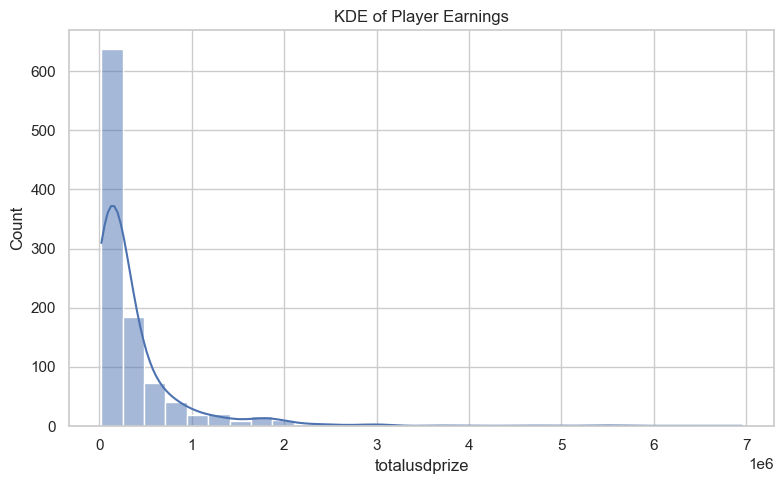

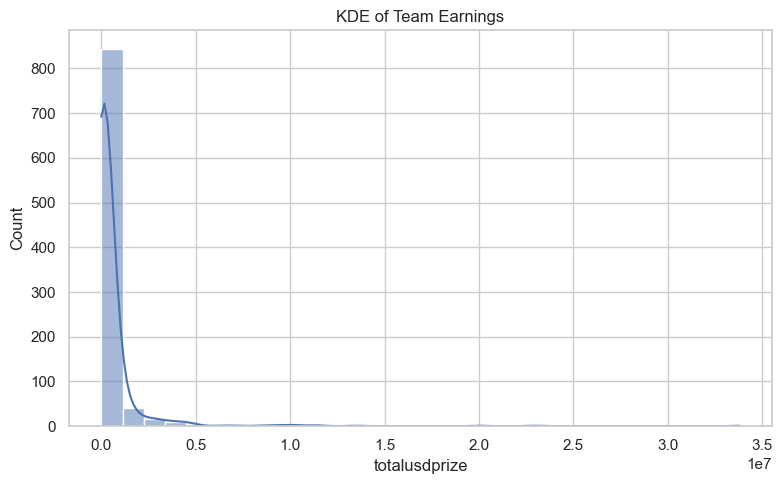

In [64]:
if "totalusdprize" in df_players_merged.columns:
    safe_histplot(df_players_merged, "totalusdprize", "KDE of Player Earnings")

if "totalusdprize" in df_teams.columns:
    safe_histplot(df_teams, "totalusdprize", "KDE of Team Earnings")

QQ-plot example: player earnings log-transformed

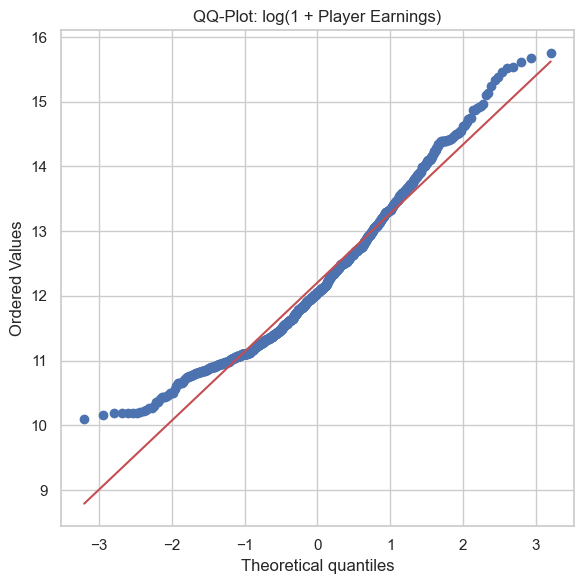

In [65]:
if "totalusdprize" in df_players_merged.columns:
    earnings = ensure_numeric_series(df_players_merged["totalusdprize"]).dropna()
    log_earnings = np.log1p(earnings)
    plt.figure(figsize=(6, 6))
    probplot(log_earnings, dist="norm", plot=plt)
    plt.title("QQ-Plot: log(1 + Player Earnings)")
    plt.tight_layout()
    plt.show()

#### Machine Learning Models

All models:
- Trained **from scratch**
- Saved to `models/`
- Reloaded and used for sample predictions

#### Regression – Predict Hours Watched from Average & Peak Viewers

Prepare regression dataset from twitch games

In [66]:
reg_hours_col = hours_col
reg_avg_col = avg_viewers_games_col
reg_peak_col = peak_viewers_games_col

Fallback: if avg/peak not found, use any other numeric columns

In [67]:
numeric_cols_games = df_twitch_games.select_dtypes(include=[np.number]).columns.tolist()

if reg_hours_col is None and numeric_cols_games:
    reg_hours_col = numeric_cols_games[0]
    print(f"[Regression] Falling back to '{reg_hours_col}' as target (hours watched).")

feature_candidates = []

if reg_avg_col:
    feature_candidates.append(reg_avg_col)
if reg_peak_col:
    feature_candidates.append(reg_peak_col)

if not feature_candidates:
    # Use first 2 numeric columns excluding target
    fallback_features = [c for c in numeric_cols_games if c != reg_hours_col][:2]
    feature_candidates = fallback_features
    print(f"[Regression] Falling back to numeric features: {feature_candidates}")

print("Regression target:", reg_hours_col)
print("Regression features:", feature_candidates)

Regression target: watch_time(minutes)
Regression features: ['average_viewers', 'peak_viewers']


Build X, Y

In [68]:
df_reg = df_twitch_games.dropna(subset=[reg_hours_col] + feature_candidates).copy()
X_reg = df_reg[feature_candidates]
y_reg = df_reg[reg_hours_col]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

Regression pipeline

In [69]:
regression_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LinearRegression()),
    ]
)

Train regression model

In [70]:
regression_pipeline.fit(X_train_reg, y_train_reg)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


Evaluate regression model

In [71]:
y_pred_reg = regression_pipeline.predict(X_test_reg)
mse_reg = mean_squared_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)
print(f"Regression MSE: {mse_reg:.2f}")
print(f"Regression R²: {r2_reg:.3f}")

Regression MSE: 121661711354292032.00
Regression R²: 0.121


Save regression model

In [72]:
regression_model_path = os.path.join(MODELS_DIR, "regression_hours_watched.pkl")
with open(regression_model_path, "wb") as f:
    pickle.dump(
        {
            "pipeline": regression_pipeline,
            "features": feature_candidates,
            "target": reg_hours_col,
        },
        f,
    )
print("Saved regression model to:", regression_model_path)

Saved regression model to: models\regression_hours_watched.pkl


Load regression model

In [73]:
with open(regression_model_path, "rb") as f:
    reg_bundle_loaded = pickle.load(f)

regression_pipeline_loaded = reg_bundle_loaded["pipeline"]
print("Loaded regression model.")

Loaded regression model.


Sample predictions

In [74]:
sample_reg = X_test_reg.head(5)
preds_reg = regression_pipeline_loaded.predict(sample_reg)

reg_results = sample_reg.copy()
reg_results["actual_hours_watched"] = y_test_reg.loc[sample_reg.index]
reg_results["predicted_hours_watched"] = preds_reg
reg_results

,average_viewers,peak_viewers,actual_hours_watched,predicted_hours_watched
521,3337,11480,227675805,2.813286e+08
737,1821,11518,166352115,2.728657e+08
740,2488,7592,165015915,2.563935e+08
660,2122,82047,181075290,6.389443e+08
411,1904,23448,284645955,3.349713e+08


#### Classification – Predict Game Popularity Tier

Ensure popularity_tier exists

In [75]:
if "popularity_tier" not in df_twitch_games.columns:
    raise ValueError("popularity_tier not found. Run popularity tier section first.")

Build classification dataset

In [76]:
class_features = []

for col_candidate in [avg_viewers_games_col, peak_viewers_games_col, hours_col]:
    if col_candidate and col_candidate in df_twitch_games.columns:
        class_features.append(col_candidate)

class_target = "popularity_tier"

df_class = df_twitch_games.dropna(subset=class_features + [class_target]).copy()

X_class = df_class[class_features]
y_class = df_class[class_target]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print("Classification features:", class_features)
print("Target:", class_target)


Classification features: ['average_viewers', 'peak_viewers', 'watch_time(minutes)']
Target: popularity_tier


Classification pipeline (Logistic Regression)

In [77]:
classification_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, multi_class="multinomial")),
    ]
)

classification_pipeline.fit(X_train_cls, y_train_cls)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Evaluate classifier

In [78]:
y_pred_cls = classification_pipeline.predict(X_test_cls)
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_cls))

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.87      0.93        68
         Low       0.85      0.95      0.90        66
      Medium       0.82      0.83      0.83        66

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



Confusion matrix heatmap

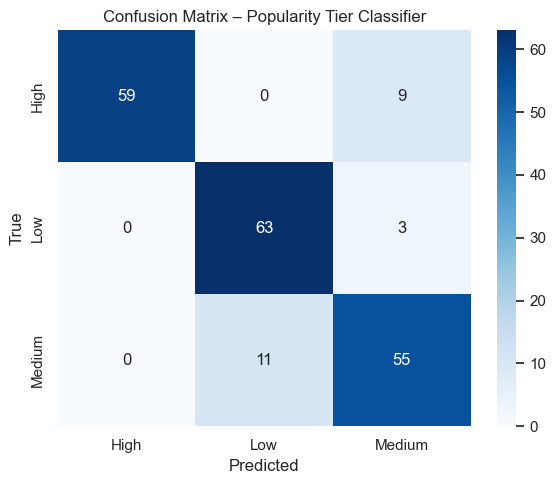

In [79]:
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=sorted(y_class.unique()))
cm_df = pd.DataFrame(cm, index=sorted(y_class.unique()), columns=sorted(y_class.unique()))

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Popularity Tier Classifier")
plt.tight_layout()
plt.show()

Save classifier with joblib

In [80]:
classifier_path = os.path.join(MODELS_DIR, "popularity_classifier.pkl")
joblib.dump({"pipeline": classification_pipeline, "features": class_features}, classifier_path)
print("Saved classifier to:", classifier_path)

Saved classifier to: models\popularity_classifier.pkl


Load classifier

In [81]:
classifier_bundle_loaded = joblib.load(classifier_path)
classification_pipeline_loaded = classifier_bundle_loaded["pipeline"]
print("Loaded classifier.")

Loaded classifier.


Sample predictions

In [82]:
sample_cls = X_test_cls.head(5)
preds_cls = classification_pipeline_loaded.predict(sample_cls)

cls_results = sample_cls.copy()
cls_results["true_tier"] = y_test_cls.loc[sample_cls.index]
cls_results["predicted_tier"] = preds_cls
cls_results

,average_viewers,peak_viewers,watch_time(minutes),true_tier,predicted_tier
310,6530,74949,357966315,High,High
438,2999,20746,265426125,Medium,Medium
795,2647,19298,155187570,Low,Low
793,2690,21594,155731920,Low,Low
628,1659,9408,191523465,Medium,Low


#### Clustering – Team Performance (KMeans)

Prepare clustering data for teams

In [83]:
required_team_cols = ["totalusdprize", "totaltournaments"]

missing_team_cols = [c for c in required_team_cols if c not in df_teams.columns]
if missing_team_cols:
    raise KeyError(f"Missing team columns for clustering: {missing_team_cols}")

df_clusters = df_teams.dropna(subset=required_team_cols).copy()
X_cluster = df_clusters[required_team_cols]

Standardize and KMeans clustering

In [84]:
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

kmeans_cluster = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = kmeans_cluster.fit_predict(X_cluster_scaled)

df_clusters["cluster"] = cluster_labels

Silhouette score

In [85]:
sil_score = silhouette_score(X_cluster_scaled, cluster_labels)
print(f"Silhouette score (KMeans, k=4): {sil_score:.3f}")

Silhouette score (KMeans, k=4): 0.732


Merge cluster labels back into df_teams

In [86]:
df_teams_clean_clustered = df_teams.merge(
    df_clusters[["teamname", "cluster"]],
    on="teamname",
    how="left",
)
df_teams_clean_clustered["cluster"].fillna(-1, inplace=True)
df_teams_clean_clustered["cluster"] = df_teams_clean_clustered["cluster"].astype(int)

df_teams_clean_clustered.head()

,teamid,teamname,totalusdprize,totaltournaments,game,genre,continent_name,continent_code,cluster
0,760,San Francisco Shock,3105000.0,7,Overwatch,First-Person Shooter,Unknown,UNK,0
1,776,London Spitfire,1591136.5,13,Overwatch,First-Person Shooter,Unknown,UNK,0
2,768,New York Excelsior,1572618.5,18,Overwatch,First-Person Shooter,Unknown,UNK,0
3,773,Philadelphia Fusion,1186278.5,15,Overwatch,First-Person Shooter,Unknown,UNK,0
4,766,Seoul Dynasty,1130000.0,6,Overwatch,First-Person Shooter,Unknown,UNK,0


Scatter plot: totalusdprize vs totaltournaments by cluster

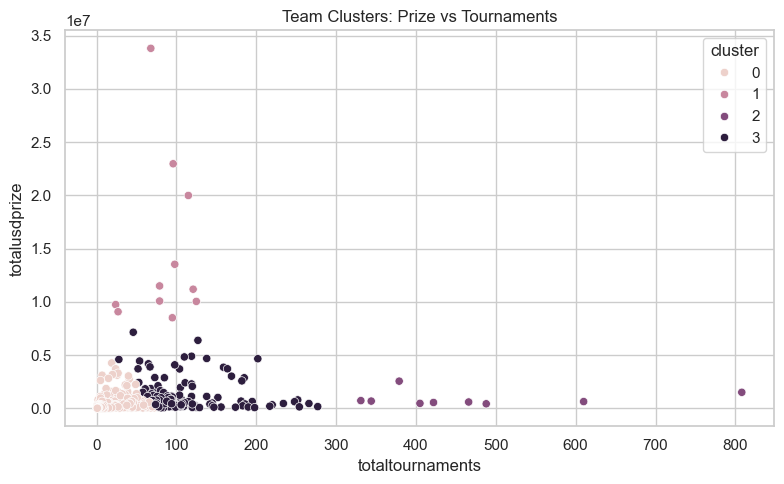

In [87]:
safe_scatter(
    df_clusters,
    x="totaltournaments",
    y="totalusdprize",
    hue="cluster",
    title="Team Clusters: Prize vs Tournaments",
)

Save clustering model bundle (scaler + kmeans + feature names)

In [88]:
cluster_model_path = os.path.join(MODELS_DIR, "team_cluster_model.pkl")
with open(cluster_model_path, "wb") as f:
    pickle.dump(
        {
            "scaler": scaler_cluster,
            "kmeans": kmeans_cluster,
            "features": required_team_cols,
        },
        f,
    )
print("Saved team clustering model to:", cluster_model_path)

Saved team clustering model to: models\team_cluster_model.pkl


Load clustering model

In [89]:
with open(cluster_model_path, "rb") as f:
    cluster_bundle_loaded = pickle.load(f)

scaler_loaded = cluster_bundle_loaded["scaler"]
kmeans_loaded = cluster_bundle_loaded["kmeans"]
cluster_features_loaded = cluster_bundle_loaded["features"]
print("Loaded clustering model.")

Loaded clustering model.


Sample cluster predictions

In [90]:
sample_teams = df_teams[cluster_features_loaded].dropna().head(5)
sample_scaled = scaler_loaded.transform(sample_teams)
sample_cluster_labels = kmeans_loaded.predict(sample_scaled)

sample_cluster_results = df_teams.loc[sample_teams.index, ["teamname"] + cluster_features_loaded].copy()
sample_cluster_results["cluster_predicted"] = sample_cluster_labels
sample_cluster_results

,teamname,totalusdprize,totaltournaments,cluster_predicted
0,San Francisco Shock,3105000.0,7,0
1,London Spitfire,1591136.5,13,0
2,New York Excelsior,1572618.5,18,0
3,Philadelphia Fusion,1186278.5,15,0
4,Seoul Dynasty,1130000.0,6,0


#### ARIMA Forecasting – Revenue / Audience


Choose target column: revenue if available, else audience

In [91]:
target_col_growth = revenue_col if revenue_col else audience_col
print("ARIMA target column:", target_col_growth)

if target_col_growth is None:
    raise ValueError("No suitable revenue/audience column available for ARIMA.")

ARIMA target column: gaming_revenue_billionusd


Prepare time series 2020–2025

In [92]:
ts_df = df_growth_2020_2025.dropna(subset=[target_col_growth]).copy()
ts_df.sort_values(year_col, inplace=True)

ts_series = ensure_numeric_series(ts_df[target_col_growth])
ts_series.index = pd.Index(ts_df[year_col].astype(int), name="year")

ts_series

year
2020     53.72
2020     40.36
2020     45.82
2020     75.86
2020     58.19
         ...  
2025    188.48
2025      3.86
2025      6.78
2025     92.23
2025     84.27
Name: gaming_revenue_billionusd, Length: 150, dtype: float64

Fit ARIMA(1,1,1)

In [93]:
import warnings
warnings.filterwarnings("ignore")

arima_model = ARIMA(ts_series, order=(1, 1, 1))
arima_results = arima_model.fit()
print(arima_results.summary())

                                   SARIMAX Results                                   
Dep. Variable:     gaming_revenue_billionusd   No. Observations:                  150
Model:                        ARIMA(1, 1, 1)   Log Likelihood                -808.564
Date:                       Tue, 09 Dec 2025   AIC                           1623.128
Time:                               21:52:29   BIC                           1632.140
Sample:                                    0   HQIC                          1626.790
                                       - 150                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1407      0.080     -1.755      0.079      -0.298       0.016
ma.L1         -0.9454      0.027    -35.190      0.000      -0.998      -0.

Forecast next 5 years

In [94]:
n_forecast = 5
forecast_res = arima_results.get_forecast(steps=n_forecast)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

future_years = np.arange(ts_series.index.max() + 1, ts_series.index.max() + 1 + n_forecast)
forecast_mean.index = future_years
forecast_ci.index = future_years

forecast_mean, forecast_ci.head()

(2026    93.144254
 2027    91.895449
 2028    92.071183
 2029    92.046454
 2030    92.049934
 Name: predicted_mean, dtype: float64,
       lower gaming_revenue_billionusd  upper gaming_revenue_billionusd
 2026                       -13.787098                       200.075606
 2027                       -15.432040                       199.222938
 2028                       -15.492959                       199.635326
 2029                       -15.626133                       199.719041
 2030                       -15.745981                       199.845849)

Plot historical + forecast

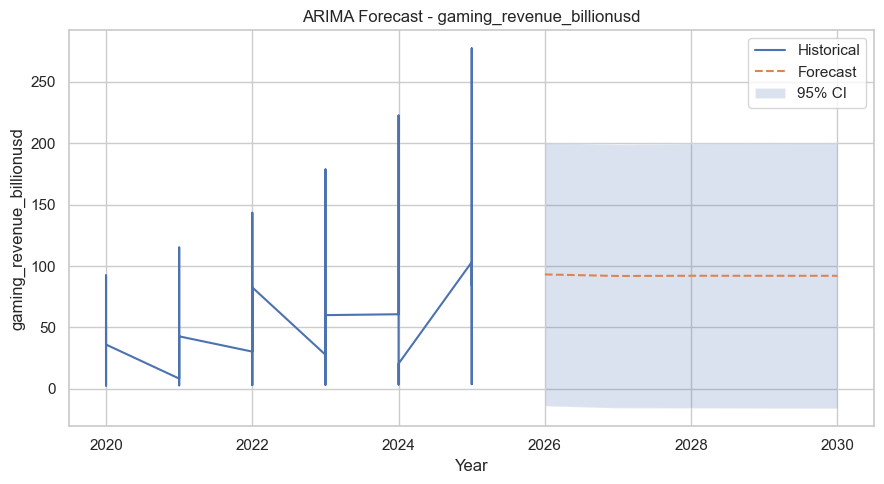

In [95]:
plt.figure(figsize=(9, 5))
plt.plot(ts_series.index, ts_series.values, label="Historical")
plt.plot(forecast_mean.index, forecast_mean.values, label="Forecast", linestyle="--")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% CI",
)
plt.xlabel("Year")
plt.ylabel(target_col_growth)
plt.title(f"ARIMA Forecast - {target_col_growth}")
plt.legend()
plt.tight_layout()
plt.show()

Save ARIMA model

In [96]:
arima_model_path = os.path.join(MODELS_DIR, "arima_forecast.pkl")
arima_results.save(arima_model_path)
print("Saved ARIMA model to:", arima_model_path)

Saved ARIMA model to: models\arima_forecast.pkl


Load ARIMA model

In [97]:
arima_loaded = ARIMAResults.load(arima_model_path)
print("Loaded ARIMA model.")

Loaded ARIMA model.


Forecast again using loaded model

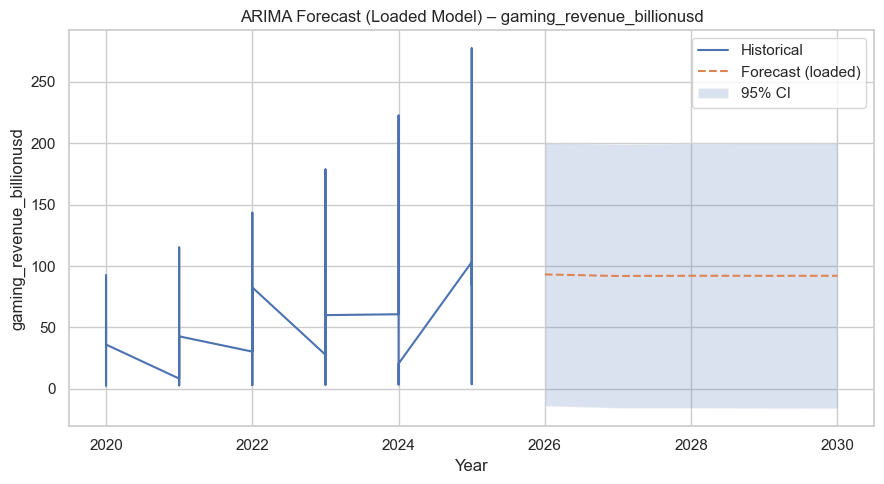

In [98]:
forecast_res_loaded = arima_loaded.get_forecast(steps=n_forecast)
forecast_mean_loaded = forecast_res_loaded.predicted_mean
forecast_ci_loaded = forecast_res_loaded.conf_int()

forecast_mean_loaded.index = future_years
forecast_ci_loaded.index = future_years

plt.figure(figsize=(9, 5))
plt.plot(ts_series.index, ts_series.values, label="Historical")
plt.plot(forecast_mean_loaded.index, forecast_mean_loaded.values, label="Forecast (loaded)", linestyle="--")
plt.fill_between(
    forecast_ci_loaded.index,
    forecast_ci_loaded.iloc[:, 0],
    forecast_ci_loaded.iloc[:, 1],
    alpha=0.2,
    label="95% CI",
)
plt.xlabel("Year")
plt.ylabel(target_col_growth)
plt.title(f"ARIMA Forecast (Loaded Model) – {target_col_growth}")
plt.legend()
plt.tight_layout()
plt.show()

#### Build a summary table of key insights (example entries)

In [99]:
insights_data = [
    {
        "Area": "Players",
        "Insight": "Player earnings are highly skewed with a small elite capturing most prize money.",
        "Business implication": "Organizations can design tiered support programs to nurture mid-tier players and reduce drop-off.",
    },
    {
        "Area": "Teams",
        "Insight": "Team earnings and tournament participation cluster into four distinct performance groups.",
        "Business implication": "Sponsors can target clusters differently – elite teams for visibility, growth clusters for value buys.",
    },
    {
        "Area": "Regions",
        "Insight": "Certain continents account for a dominant share of total player earnings.",
        "Business implication": "Leagues expanding into under-represented regions may capture untapped talent and audiences.",
    },
    {
        "Area": "Games",
        "Insight": "A handful of titles account for the majority of player and team earnings.",
        "Business implication": "Event organizers should balance top-tier titles with emerging games to diversify risk.",
    },
    {
        "Area": "Twitch Streamers",
        "Insight": "Partnered channels typically achieve higher average viewership than non-partners.",
        "Business implication": "Platforms can use partner-like perks to incentivize high-potential creators before official partnership.",
    },
    {
        "Area": "Twitch Categories",
        "Insight": "Viewership is concentrated in a small number of categories by hours watched.",
        "Business implication": "Brands should focus campaigns on these top categories while testing niche segments for targeted messaging.",
    },
    {
        "Area": "Game Popularity Tiers",
        "Insight": "Popularity tiers (High / Medium / Low) derived from hours watched map well to average and peak viewers.",
        "Business implication": "Publishers can use the tier classifier to prioritize marketing and esports investment by title.",
    },
    {
        "Area": "Esports Growth",
        "Insight": "Revenue and audience show strong CAGR from 2020–2025 with sustained upward trends.",
        "Business implication": "Long-term investments in infrastructure and leagues are justified by continued growth projections.",
    },
    {
        "Area": "Forecasting",
        "Insight": "ARIMA forecasts suggest continued expansion in revenue/audience over the next 5 years.",
        "Business implication": "Stakeholders can use forecasts for budgeting, staffing, and sponsorship pricing strategies.",
    },
    {
        "Area": "Inequality",
        "Insight": "Earnings distributions for both players and teams exhibit high skewness and kurtosis.",
        "Business implication": "Revenue-sharing schemes or developmental leagues could help smooth inequality and increase ecosystem stability.",
    },
]

df_insights = pd.DataFrame(insights_data)
df_insights

,Area,Insight,Business implication
0,Players,Player earnings are highly skewed with a small...,Organizations can design tiered support progra...
1,Teams,Team earnings and tournament participation clu...,Sponsors can target clusters differently – eli...
2,Regions,Certain continents account for a dominant shar...,Leagues expanding into under-represented regio...
3,Games,A handful of titles account for the majority o...,Event organizers should balance top-tier title...
4,Twitch Streamers,Partnered channels typically achieve higher av...,Platforms can use partner-like perks to incent...
5,Twitch Categories,Viewership is concentrated in a small number o...,Brands should focus campaigns on these top cat...
6,Game Popularity Tiers,Popularity tiers (High / Medium / Low) derived...,Publishers can use the tier classifier to prio...
7,Esports Growth,Revenue and audience show strong CAGR from 202...,Long-term investments in infrastructure and le...
8,Forecasting,ARIMA forecasts suggest continued expansion in...,"Stakeholders can use forecasts for budgeting, ..."
9,Inequality,Earnings distributions for both players and te...,Revenue-sharing schemes or developmental leagu...
